# Qubit Tune-up with SHF Instruments

In this notebook we demonstrate qubit tuneup with the LabOne Q software, implemented as a sequence of experiments. 

Before starting the experiments, we define a set of initial qubit parameters, as might be known from fabrication. 

These parameters can then be used to update the baseline calibration used in the experiments.

## 0. General Imports and Definitions
### 0.1 Python Imports 

In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np

### 0.2 Function Definitions

In [2]:
# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"res_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        stop=stop_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        count=num_points,
    )

# function that returns the calibration of the readout line oscillator for spectroscopy
def res_spec_calib(frequency_sweep, amplitude_sweep=None):
    exp_calibration = Calibration()
    # sets the oscillator of the experimental measure signal
    exp_calibration["measure"] = SignalCalibration(
        # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
        oscillator=Oscillator(
            "readout_osc",
            frequency=frequency_sweep,
            modulation_type=ModulationType.HARDWARE,
        ),
        amplitude=amplitude_sweep,
    )
    return exp_calibration


# signal maps for the qubit readout only
def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

# create gaussian square pulse for readout
def create_readout_pulse(
    qubit, sigma=0.2
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined['readout_len'],
        amplitude=qubit.parameters.user_defined['readout_amp'],
        width=qubit.parameters.user_defined['readout_len'] * 0.9,
        sigma=sigma,
    )
    return readout_pulse

# qubit spectroscopy freq sweep
def create_drive_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"drive_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        stop=stop_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        count=num_points,
    )

# define square pulse for qubit spec
def create_drive_spec_pulse(qubit, amp = 0.95):
    pulse = pulse_library.const(
        uid=f"drive_spec_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=amp, #max power to start
    )
    return pulse

# signal map for qubit drive and readout
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

#define gaussian pulse for qubit drive
def create_rabi_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1,
    )

# define qubit drive rabi sweep
def create_rabi_amp_sweep(qubit, amp_num, uid="rabi_amp"):
    amp_min = 0.1
    amp_max = min([qubit.parameters.user_defined['amplitude_pi'] * 2.2, 1.0])
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

# define delay time sweep for Ramsey, T1, echo
def create_delay_sweep(
    start=0, stop=50e-6, count=100, axis_name="Time [s]"
):
    time_sweep = LinearSweepParameter(
        uid="time_sweep_param", start=start, stop=stop, count=count, axis_name=axis_name
    )
    return time_sweep

# define ramsey drive pulse
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'] / 2,
    )

# define T1 drive pulse
def create_T1_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

def create_pi_2_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_2_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']/2,
    )

def create_pi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

## 1. Define the Instrument Setup and Required Experimental Parameters
### 1.1 Create device setup

Create the device setup from the descriptor, and apply some convenient mapping to instruments and logical signals.

In [3]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12237
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/2/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

In [4]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

### 1.2 Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings

May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [5]:
q0 = Transmon.from_logical_signal_group(
    "q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.15e9,     #Drive frequency for qubit ge transition
        resonance_frequency_ef=2.95e9,     #Drive frequency for qubit ef transtion
        drive_lo_frequency=6.5e9,          #Center frequency for qubit drive, needs to be within 500 MHz of both ge and ef frequencies
        readout_resonator_frequency=6.040e9, #Readout frequency for readout resonator
        readout_lo_frequency=6.5e9,        #Center frequency for readout line, shared node, all qubits need to have the same value
        readout_integration_delay=60e-9,       #Propogation delay for readout aqcuire line, relative to default 212 ns, shared node, all qubits need to have the same value
        drive_range = 10,                  #Output range for qubit drive in dBm
        readout_range_out = -0,             #Output range for readout resonator in dBm, shared node, all qubits need to have the same value
        readout_range_in = -15,              #Input range for readout resonator in dBm, shared node, all qubits need to have the same value
        
        user_defined={                     #Pulse Parameters to be included as user_defined
            "amplitude_pi": 0.99,           #Amplitude of Pi pulse, linear gain from 0 to 1 of drive_range
            "pulse_length": 50e-9,         #Length of drive/Pi pulse
            "readout_len": 2e-6,           #Length of readout pulse
            "readout_amp": 0.98,           #Amplitude of readout pulse, linear gain from 0 to 1 of readout_range_out, starts at 1 for spectroscopy
            "reset_length": 5e-6,          #Relaxation time to return to ground state
        },
    ),
)

q1 = Transmon.from_logical_signal_group(
    "q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=6.25e9,
        resonance_frequency_ef=5.95e9,
        drive_lo_frequency=7.1e9,
        readout_resonator_frequency=7.4e9,
        readout_lo_frequency=q0.parameters.readout_lo_frequency, #Shared node, needs to match q0 center frequency
        readout_integration_delay=q0.parameters.readout_integration_delay, #Shared node, needs to match q0
        drive_range = 10,
        readout_range_out = q0.parameters.readout_range_out, #Shared node, needs to match q0
        readout_range_in = q0.parameters.readout_range_in, #Shared node, needs to match q0
        user_defined={
            "amplitude_pi": 0.6,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.98,
            "reset_length": 5e-6,
        },
    ),
)

In [6]:
#Finish calibrating SHFQC with qubit parameters
qubits = [q0, q1]
for qubit in qubits:
    device_setup.set_calibration(qubit.calibration())

#Choose which qubit will be measured
measure_q = q0

### 2.2 Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments

In [7]:
# perform experiments in emulation mode or on hardware - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.07.29 14:27:10.511] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\laboneq_output\log
[2024.07.29 14:27:10.516] INFO    VERSION: laboneq 2.32.0
[2024.07.29 14:27:10.521] INFO    Connecting to data server at localhost:8004
[2024.07.29 14:27:10.649] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.07.29 14:27:13.513] WARNING SHFQC/QA:dev12237: Include the device options 'SHFQC/PLUS/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.07.29 14:27:14.599] INFO    Configuring the device setup
[2024.07.29 14:27:14.709] INFO    The device setup is configured


## 3. Qubit Tuneup - Experimental Sequence

Sequence of experiments for tuneup from scratch of a superconducting qubit in circuit QED architecture 

### 3.1 Resonator Spectroscopy: CW

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line

#### 3.1.1 Additional Experimental Parameters

Define the frequency scan

#### 3.1.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [26]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec

#### 3.1.3 Run and Evaluate Experiment
Runs the experiment and evaluates the data returned by the measurement

In [906]:
measure_q.parameters.readout_range_out = 0
measure_q.parameters.readout_range_in = -15
# measure_q.parameters.readout_range_out = 10
# measure_q.parameters.readout_range_in = 5
measure_q.parameters.user_defined['readout_amp'] = 0.9

In [907]:
# measure_q.parameters.readout_lo_frequency = 6.5e9
# measure_q.parameters.readout_resonator_frequency = 6.5e9

In [908]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=900000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1200000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=0,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [12]:
device_setup.set_calibration(measure_q.calibration())

In [13]:
# measure_q.parameters.readout_lo_frequency
measure_q.parameters.readout_resonator_frequency = 6.25e9

In [14]:
measure_q.parameters.readout_resonator_frequency

6250000000.0

In [15]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -250e6
stop_freq = 250e6
num_points = 10001
integration_time = 6e-2
num_averages = 1

In [16]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [21]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.07.08 10:55:27.184] INFO    Starting LabOne Q Compiler run...
[2024.07.08 10:55:28.156] INFO    Schedule completed. [0.969 s]
[2024.07.08 10:55:29.737] INFO    Code generation completed for all AWGs. [1.579 s]
[2024.07.08 10:55:29.738] INFO    Completed compilation step 1 of 1. [2.552 s]
[2024.07.08 10:55:29.742] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.08 10:55:29.743] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.08 10:55:29.744] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.08 10:55:29.745] INFO      device_shfqc     0         25            0           0         0  
[2024.07.08 10:55:29.747] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.08 10:55:29.748] INFO      TOTAL                      25            0                     0  
[2024.07.08 10:55:29.749] INFO     ────────────────────────────────────────────────────

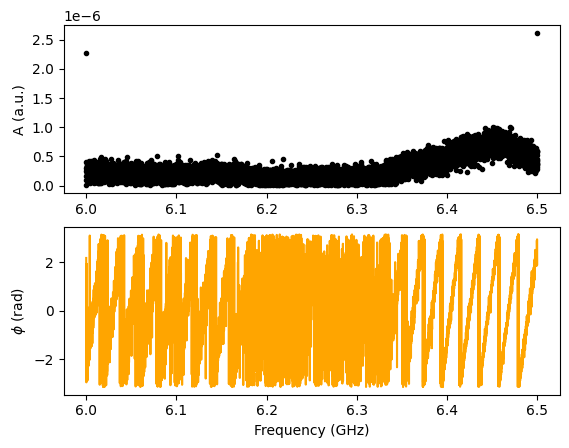

In [22]:
electrical_delay = 49.25e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
# _phase = _delay*spec_freq*np.angle(spec_res)
# ax2.plot(spec_freq / 1e9, _phase, "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(6582311900.0/1e9)

plt.show()

# R6, Q0 (F-C0)

In [79]:
measure_q.parameters.readout_range_out = -10
measure_q.parameters.readout_range_in = 0

In [80]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [81]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -20e6
stop_freq = 20e6
num_points = 201
integration_time = 5e-2
num_averages = 1

In [82]:
res = (stop_freq + (-start_freq))/(num_points*1e6)
print(f'resolution = {res} MHz')

resolution = 0.19900497512437812 MHz


In [83]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [84]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.07.29 14:54:55.882] INFO    Starting LabOne Q Compiler run...
[2024.07.29 14:54:55.956] INFO    Schedule completed. [0.066 s]
[2024.07.29 14:54:56.043] INFO    Code generation completed for all AWGs. [0.084 s]
[2024.07.29 14:54:56.046] INFO    Completed compilation step 1 of 1. [0.157 s]
[2024.07.29 14:54:56.056] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 14:54:56.059] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 14:54:56.062] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 14:54:56.064] INFO      device_shfqc     0         25            0           0         0  
[2024.07.29 14:54:56.067] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 14:54:56.069] INFO      TOTAL                      25            0                     0  
[2024.07.29 14:54:56.071] INFO     ────────────────────────────────────────────────────

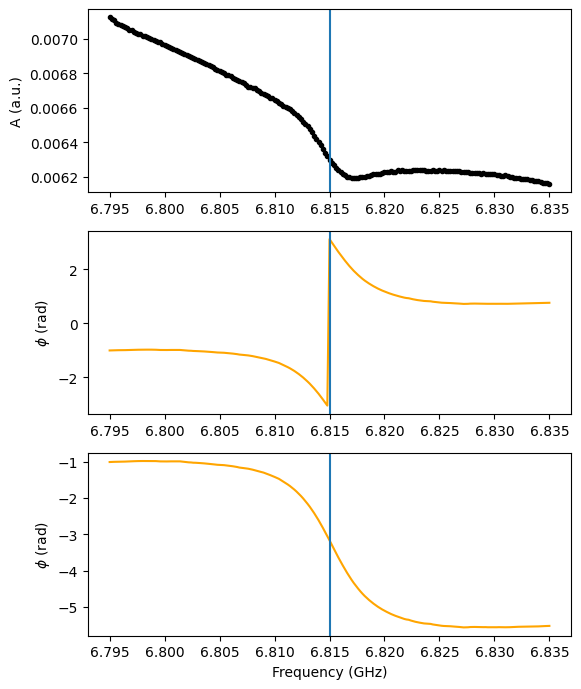

In [90]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.815]
for _vl in vl:
    ax1.axvline(vl, ls='-', color='tab:blue')
    ax2.axvline(vl, ls='-', color='tab:blue')
    ax3.axvline(vl, ls='-', color='tab:blue')

plt.tight_layout()
plt.show()

## center freq fit

In [ ]:
#Lorentzian fit requires roughly close starting values
(p_opt, b) = lorentzian.fit(
    spec_freq,
    abs(spec_res),
    100e3,
    q0.parameters.readout_resonator_frequency,
    -1e7,
    1,
    plot=True,
)
opt_freq = p_opt[1]
print(f"Resonant frequency: {opt_freq} GHz")

## Punch out 

In [124]:
measure_q.parameters.readout_range_out = -20
measure_q.parameters.readout_range_in = -10

In [125]:
# measure_q.parameters.readout_lo_frequency
measure_q.parameters.readout_resonator_frequency = 6.815e9

In [126]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [166]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -10e6
stop_freq = 10e6
num_points = 201
integration_time = 5e-2
num_averages = 1

In [167]:
# set number of points for amplitude sweep
num_amp_points = 21

In [168]:
device_setup.set_calibration(measure_q.calibration())

#### 3.3.2 Experiment Definition

In [169]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep and amplitude sweeps as parameters


def res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive amplitude
    with exp_spec.sweep(uid="res_amp", parameter=amplitude_sweep):
        with exp_spec.acquire_loop_rt(
            uid="shots",
            count=2**num_averages,
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            #inner loop - sweep frequency
            with exp_spec.sweep(uid="res_freq", parameter=frequency_sweep):
                # readout pulse and data acquisition
                with exp_spec.section(uid="spectroscopy"):
                    # play resonator excitation pulse
                    exp_spec.play(signal="measure", pulse=readout_pulse)
                    # resonator signal readout
                    exp_spec.acquire(
                        signal="acquire",
                        handle="res_spec_pulsed",
                        length=readout_pulse.length,
                    )
                with exp_spec.section(uid="delay"):
                    # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                    exp_spec.delay(signal="measure", time=1e-6)

    return exp_spec

#### 3.3.3 Apply Experiment Parameters and Compile

In [170]:
num_freq_points = num_points

In [171]:
amplitude_sweep = LinearSweepParameter(
    uid="amp_sweep_param", start=0.01, stop=0.99, count=num_amp_points
)

readout_pulse = create_readout_pulse(measure_q)
frequency_sweep = create_readout_freq_sweep(
    measure_q, start_freq, stop_freq, num_freq_points
)

exp_spec_amp = res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
)

exp_spec_amp.set_calibration(res_spec_calib(frequency_sweep, amplitude_sweep))
exp_spec_amp.set_signal_map(res_spec_map(measure_q))

In [172]:
# compile the experiment on the open instrument session
compiled_spec_amp = session.compile(exp_spec_amp)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet(
    "Pulse_Sheets/Spectroscopy_vs_Amplitude_Pulse_Sheet", compiled_spec_amp
)

[2024.07.29 15:16:59.997] INFO    Starting LabOne Q Compiler run...
[2024.07.29 15:17:00.016] INFO    Schedule completed. [0.016 s]
[2024.07.29 15:17:00.070] INFO    Code generation completed for all AWGs. [0.053 s]
[2024.07.29 15:17:00.072] INFO    Completed compilation step 1 of 21. [0.072 s]
[2024.07.29 15:17:00.073] INFO    Skipping compilation for next step(s)...
[2024.07.29 15:17:00.076] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 15:17:00.077] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 15:17:00.079] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 15:17:00.080] INFO      device_shfqc     0         21            0           1      8000  
[2024.07.29 15:17:00.081] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 15:17:00.082] INFO      TOTAL                      21            0                  8000  
[2024.07.29

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Spectroscopy_vs_Amplitude_Pulse_Sheet_2024-07-29-15-17-00.html

In [173]:
# run the compiled experiemnt
spec_amp_results = session.run(compiled_spec_amp)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_amp_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_amp_results_{timestamp}.json")

[2024.07.29 15:17:00.225] INFO    Configuring the device setup
[2024.07.29 15:17:00.330] INFO    The device setup is configured
[2024.07.29 15:17:01.261] INFO    Starting near-time execution...
[2024.07.29 15:17:15.410] INFO    Finished near-time execution.
File saved as Results_Needed/spec_amp_results_20240729T151715.json


#### plot results

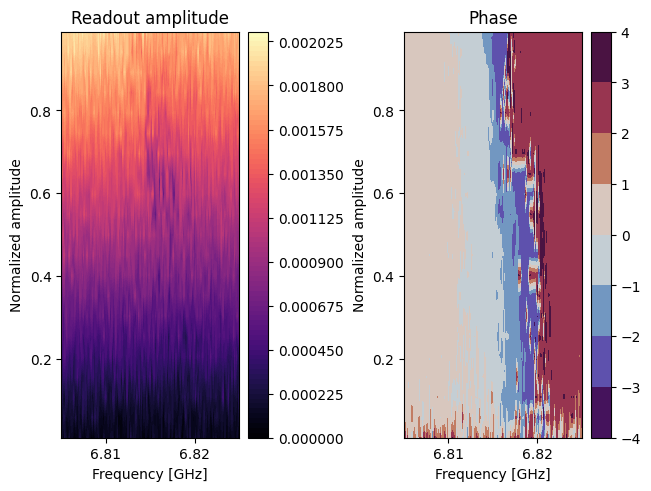

In [174]:
# plot the results
lo_freq = measure_q.parameters.readout_lo_frequency
spec_freq = lo_freq + spec_amp_results.get_axis("res_spec_pulsed")[1]
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

X, Y = np.meshgrid(spec_freq, amp)
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
CS = ax[0].contourf(X / 1e9, Y, np.abs(data), levels=100, cmap="magma")
ax[0].set_title("Readout amplitude")
ax[0].set_xlabel("Frequency [GHz]")
ax[0].set_ylabel("Normalized amplitude")
fig.colorbar(CS)

max_value = (
    max(
        # int(np.abs(np.min(np.unwrap(np.angle(data, deg=False))))),
        # int(np.abs(np.max(np.unwrap(np.angle(data, deg=False))))),
        int(np.abs(np.min(np.angle(data, deg=False)))),
        int(np.abs(np.max(np.angle(data, deg=False)))),
    )
    + 1
)

cs2_levels = np.linspace(-max_value, max_value, 2 * (max_value) + 1)

CS2 = ax[1].contourf(
    X / 1e9,
    Y,
    # np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data)),
    np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data),
    levels=cs2_levels,
    cmap="twilight_shifted",
)
ax[1].set_title("Phase")
ax[1].set_xlabel("Frequency [GHz]")
ax[1].set_ylabel("Normalized amplitude")
fig.colorbar(CS2)

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_47976\3415874774.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, [ax1, ax2] = plt.subplots(2, 1)


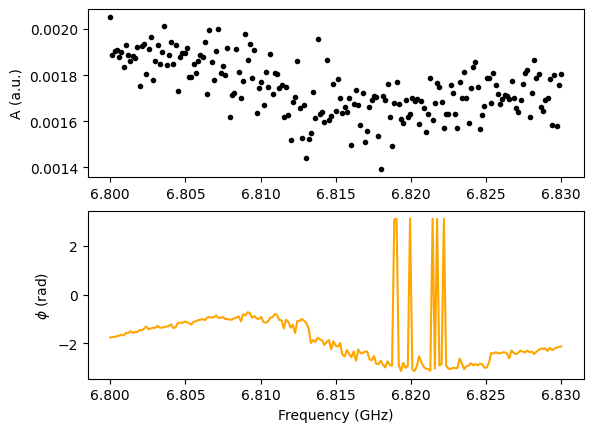

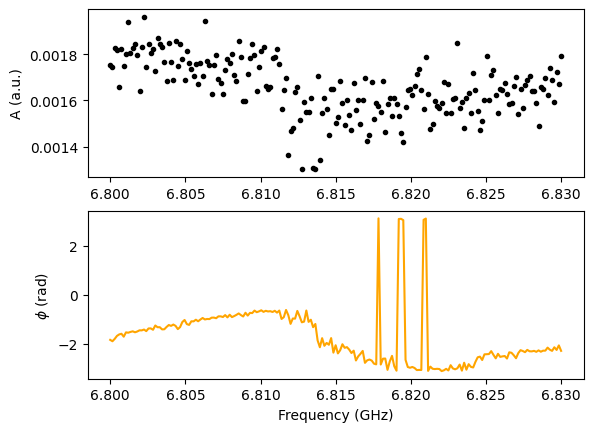

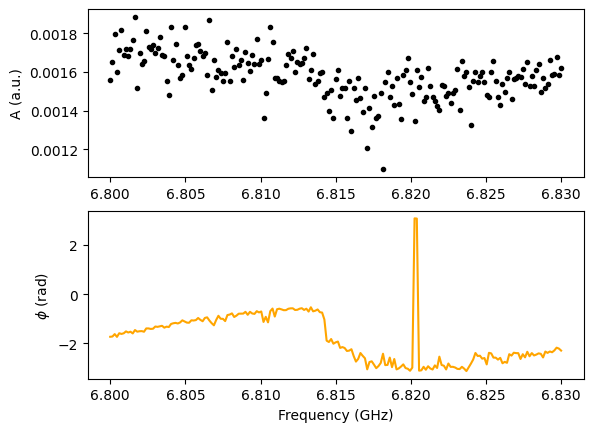

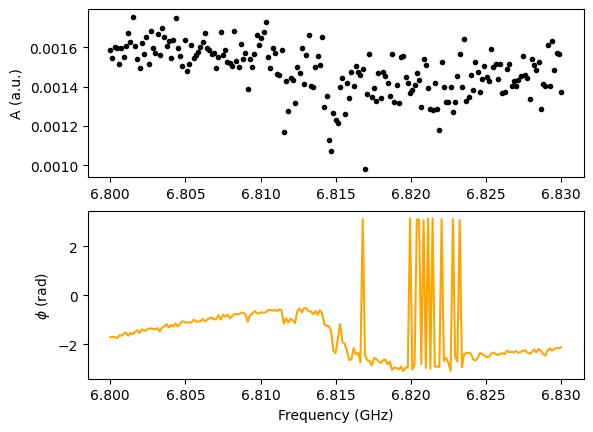

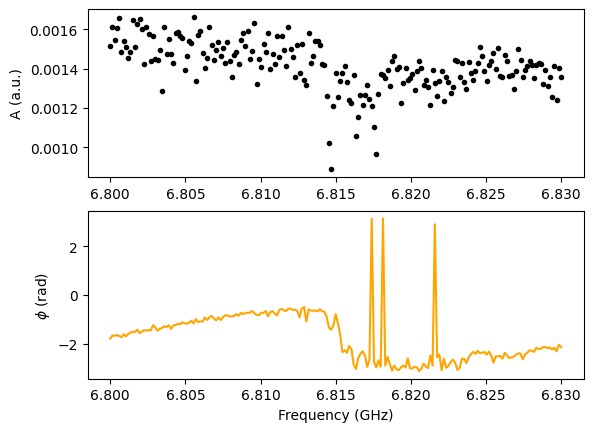

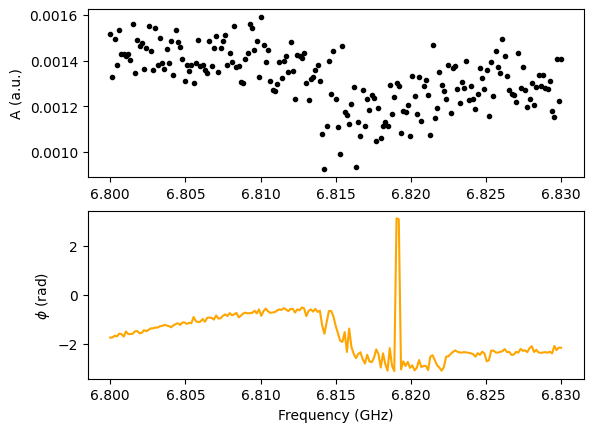

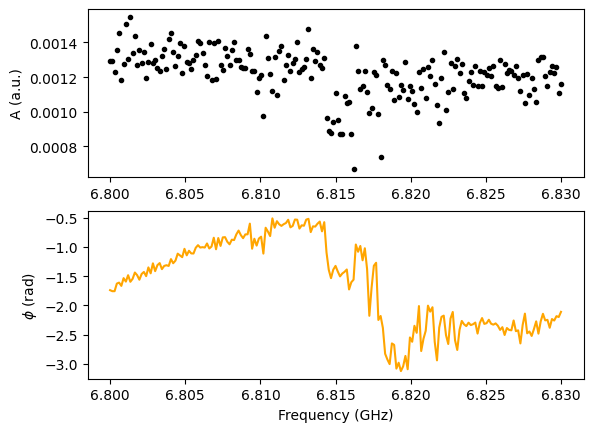

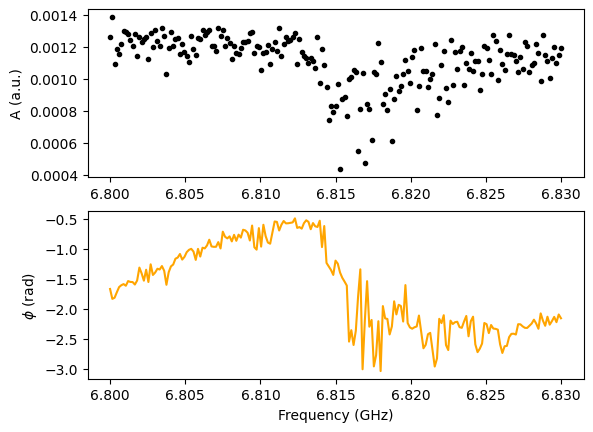

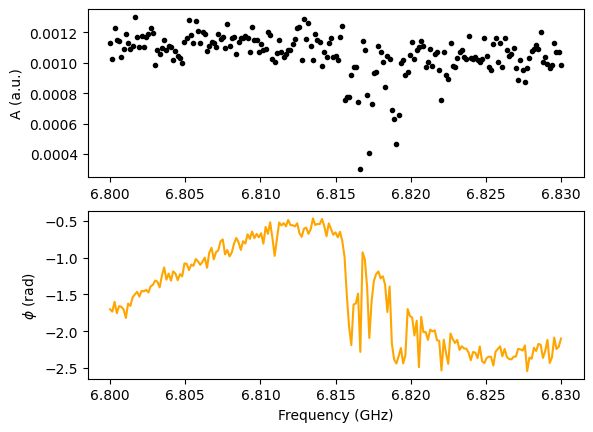

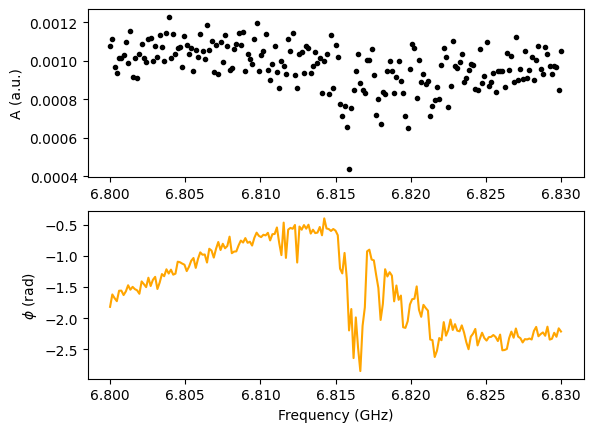

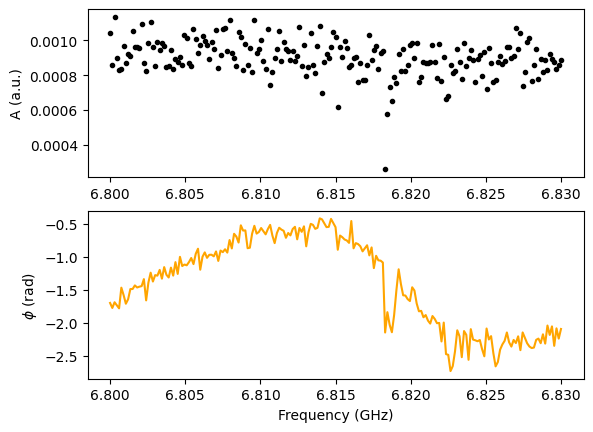

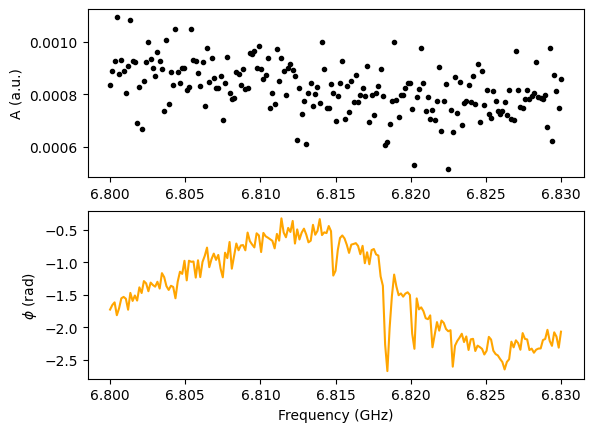

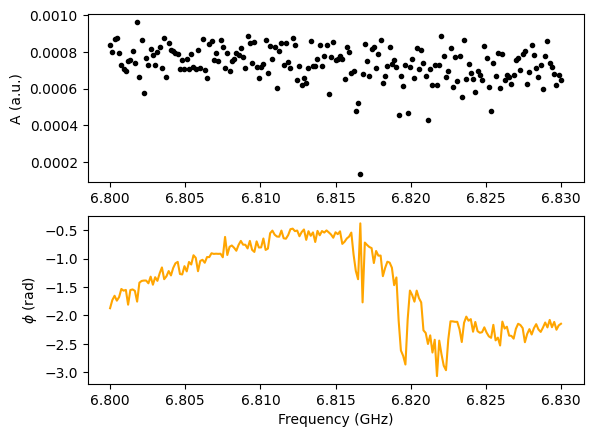

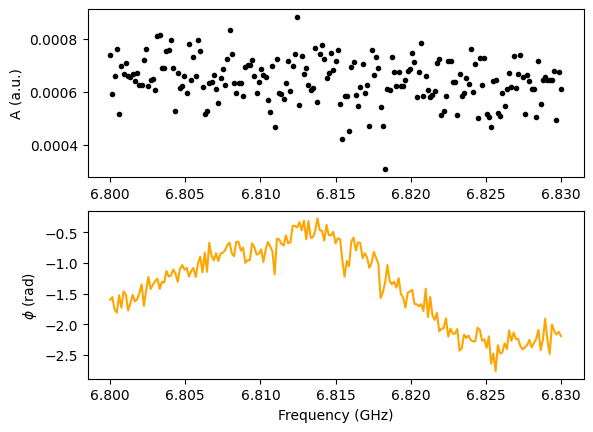

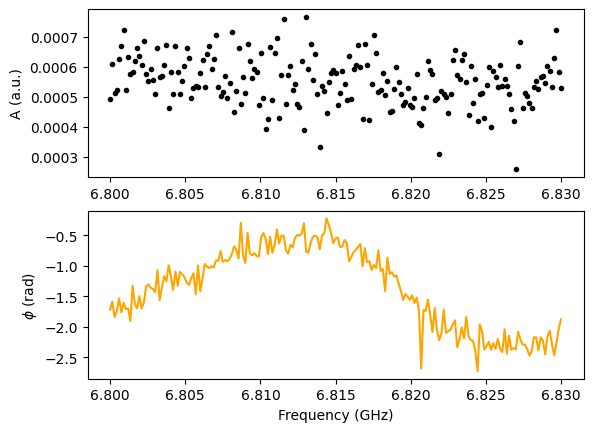

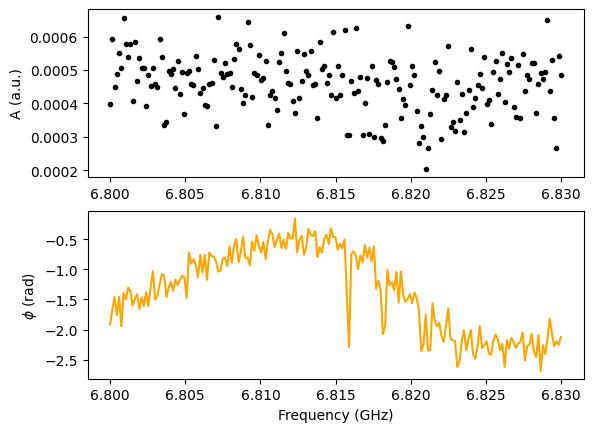

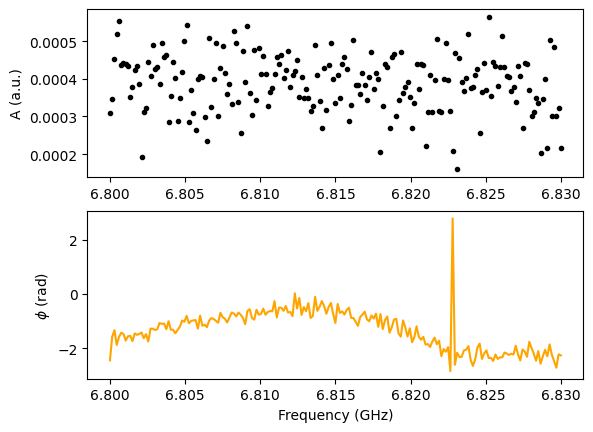

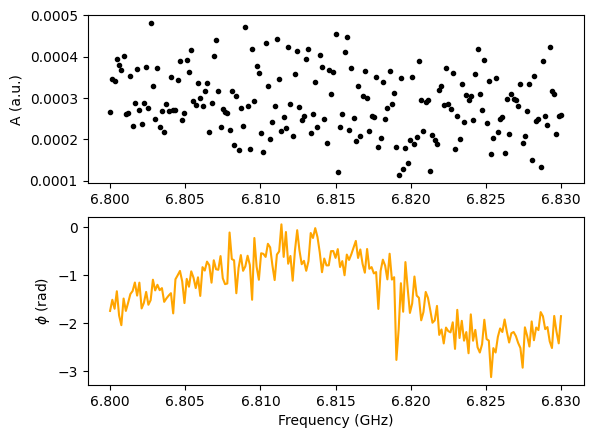

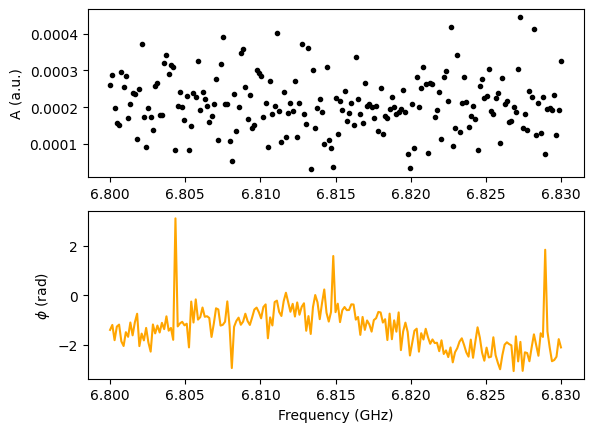

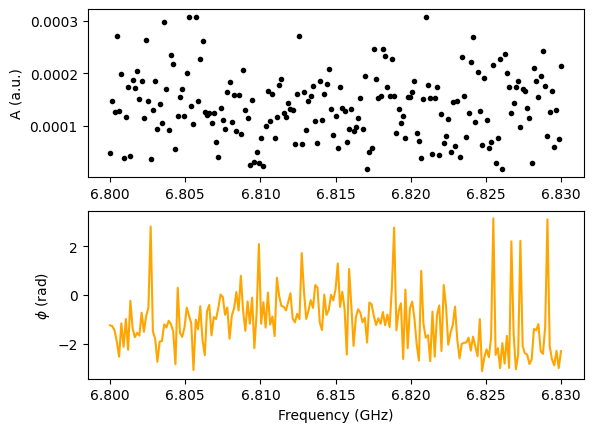

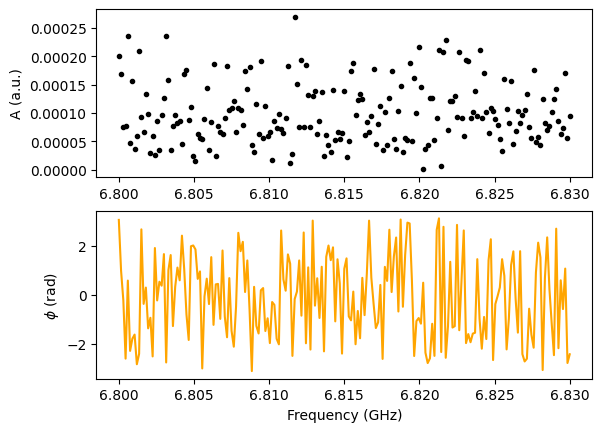

In [175]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
spec_freq = (
    measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
)
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

np.shape(spec_res)
np.shape(spec_freq)
np.shape(data)

for d in np.flip(data, axis=0):
# for d in data:
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = d
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[1]
    )

    emulate=False
    if emulate:
        # create some dummy data if running in emulation mode
        spec_res = lorentzian(
            spec_freq,
            10e6,
            measure_q.parameters.readout_resonator_frequency * (0.995 + 0.01 * np.random.rand(1)[0]),
            -2e6,
            1,
        ) + 0.1 * np.random.rand(len(spec_freq))
    
    # plot the measurement data
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
    ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
    ax1.set_ylabel("A (a.u.)")
    ax2.set_ylabel("$\\phi$ (rad)")
    ax2.set_xlabel("Frequency (GHz)")
    # ax2.axvline(spec_freq[np.argmin(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res))]/1e9)
    # spec_freq[np.argmin(abs(spec_res))]/1e9

Text(0.5, 1.0, 'Punchout phase')

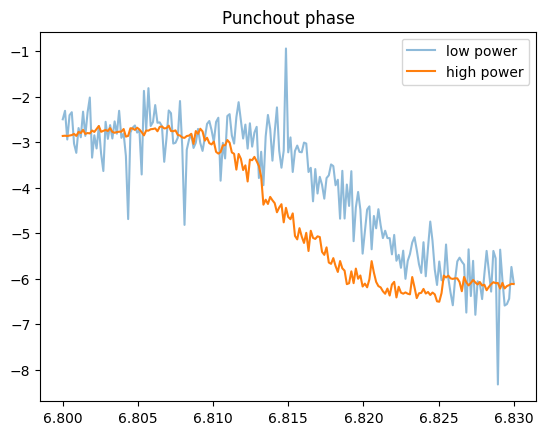

In [189]:
electrical_delay = 45.68e-9
alpha=0.5
plt.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*(data[2]))), label='low power', alpha=alpha)
plt.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*(data[-1]))), label='high power', alpha=1)
plt.legend()
plt.title('Punchout phase')

In [355]:
measure_q.parameters.user_defined['readout_range_out'] = -20
measure_q.parameters.user_defined['readout_range_in'] = -15
measure_q.parameters.user_defined['readout_amp'] = 0.1
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1100000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1100000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [547]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163500000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

## Resonator vs flux 

### resonator spectroscopy setup

In [538]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -4e6
stop_freq = 15e6
num_points = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

readout_pulse = create_readout_pulse(measure_q)

In [539]:
2**10

1024

In [540]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163500000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6815500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

#### 3.2.2 Experiment Definition

In [541]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [542]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [543]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [544]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.29 16:57:50.475] INFO    Starting LabOne Q Compiler run...
[2024.07.29 16:57:50.485] INFO    Schedule completed. [0.007 s]
[2024.07.29 16:57:50.513] INFO    Code generation completed for all AWGs. [0.027 s]
[2024.07.29 16:57:50.514] INFO    Completed compilation step 1 of 1. [0.037 s]
[2024.07.29 16:57:50.517] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 16:57:50.518] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.29 16:57:50.520] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 16:57:50.521] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.29 16:57:50.522] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.29 16:57:50.523] INFO      TOTAL                      23            0                  8000  
[2024.07.29 16:57:50.525] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-29-16-57-50.html

#### 3.2.4 Run and Evaluate Experiment

In [545]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.29 16:57:59.035] INFO    Configuring the device setup
[2024.07.29 16:57:59.147] INFO    The device setup is configured
[2024.07.29 16:58:00.173] INFO    Starting near-time execution...
[2024.07.29 16:58:01.791] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240729T165801.json


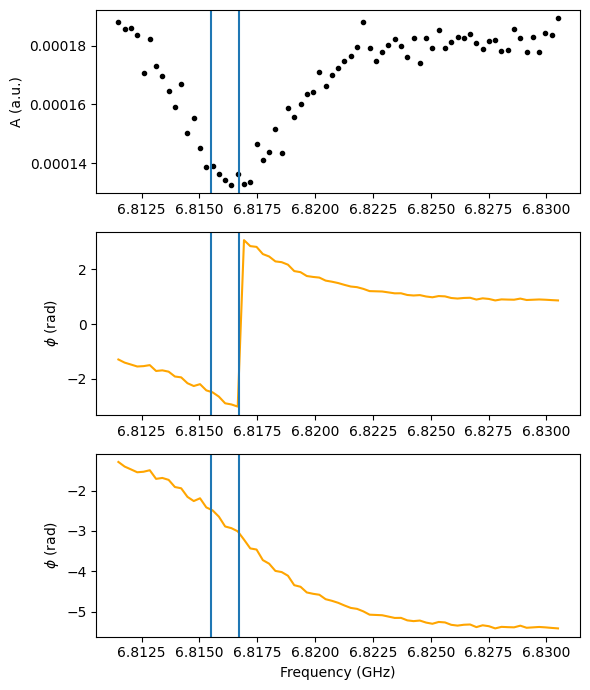

In [558]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.8155, 6.8167]
for _vl in vl:
    ax1.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax2.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax3.axvline(_vl, ls='-', 
                # color='tab:blue',
               )

plt.tight_layout()
plt.show()

### f_r vs phi ext

In [365]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.02s


KeyError: 'Another instrument has the name: yoko'

In [237]:
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [238]:
dc.output('off')
dc.source_mode('CURR')

In [239]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

In [240]:
import sys

In [254]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)

start_curr = 0.10e-3
stop_curr = 0.40e-3
current_sweep = np.linspace(start_curr,stop_curr, 101)

dc.ramp_current(0e-3, 1e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

dc.ramp_current(0,0.5e-6,0)
dc.output('off')

step 0
current: 0.0001
[2024.07.29 15:34:44.093] INFO    Configuring the device setup
[2024.07.29 15:34:44.207] INFO    The device setup is configured
[2024.07.29 15:34:45.804] INFO    Starting near-time execution...
[2024.07.29 15:34:47.512] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240729T153447.json
step 1
current: 0.00010300000000000001
[2024.07.29 15:34:49.286] INFO    Starting near-time execution...
[2024.07.29 15:34:50.998] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240729T153451.json
step 2
current: 0.000106
[2024.07.29 15:34:52.471] INFO    Starting near-time execution...
[2024.07.29 15:34:54.236] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240729T153454.json
step 3
current: 0.000109
[2024.07.29 15:34:55.899] INFO    Starting near-time execution...
[2024.07.29 15:34:57.615] INFO    Finished near-time execution.
File saved as Results_Needed/s

Text(0.5, 1.0, 'LogMag [arb.]')

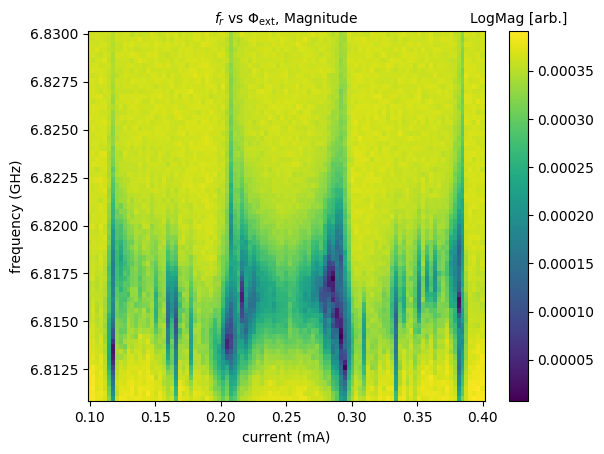

In [255]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

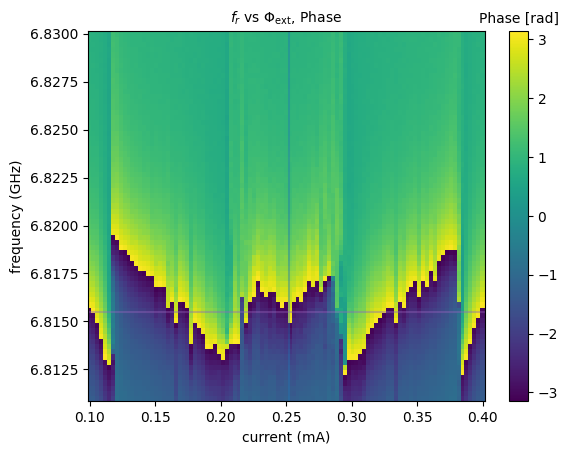

In [263]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.252, c='tab:blue', alpha=0.4)
plt.axhline(6.8155, c='tab:purple', alpha=0.4)

# R7, Q1 (F-C1)

In [974]:
measure_q.parameters.readout_range_out = -15
measure_q.parameters.readout_range_in = 0

In [975]:
measure_q.parameters.readout_resonator_frequency = 6.88e9

In [976]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [977]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -20e6
stop_freq = 20e6
num_points = 201
integration_time = 5e-2
num_averages = 1

In [978]:
res = (stop_freq + (-start_freq))/(num_points*1e6)
print(f'resolution = {res} MHz')

resolution = 0.19900497512437812 MHz


In [979]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [980]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.07.30 04:45:23.296] INFO    Starting LabOne Q Compiler run...
[2024.07.30 04:45:23.311] INFO    Schedule completed. [0.013 s]
[2024.07.30 04:45:23.338] INFO    Code generation completed for all AWGs. [0.025 s]
[2024.07.30 04:45:23.339] INFO    Completed compilation step 1 of 1. [0.041 s]
[2024.07.30 04:45:23.342] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 04:45:23.343] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 04:45:23.344] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 04:45:23.345] INFO      device_shfqc     0         25            0           0         0  
[2024.07.30 04:45:23.346] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 04:45:23.347] INFO      TOTAL                      25            0                     0  
[2024.07.30 04:45:23.348] INFO     ────────────────────────────────────────────────────

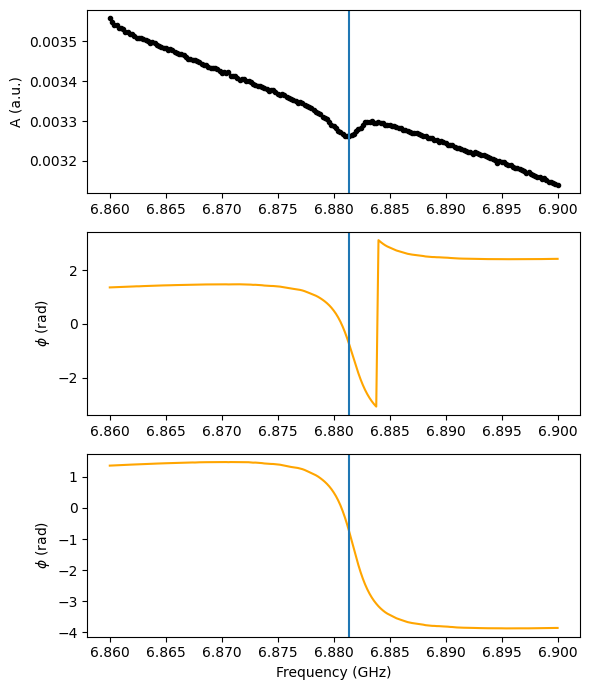

In [981]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.8814]
for _vl in vl:
    ax1.axvline(vl, ls='-', color='tab:blue')
    ax2.axvline(vl, ls='-', color='tab:blue')
    ax3.axvline(vl, ls='-', color='tab:blue')

plt.tight_layout()
plt.show()

## center freq fit

In [ ]:
#Lorentzian fit requires roughly close starting values
(p_opt, b) = lorentzian.fit(
    spec_freq,
    abs(spec_res),
    100e3,
    q0.parameters.readout_resonator_frequency,
    -1e7,
    1,
    plot=True,
)
opt_freq = p_opt[1]
print(f"Resonant frequency: {opt_freq} GHz")

## Punch out 

In [1058]:
measure_q.parameters.readout_range_out = -15
measure_q.parameters.readout_range_in = -15

In [1059]:
# measure_q.parameters.readout_lo_frequency
measure_q.parameters.readout_resonator_frequency = 6.8814e9

In [1060]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [1090]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -5e6
stop_freq = 5e6
num_points = 201
integration_time = 1e-2
num_averages = 1

In [1091]:
# set number of points for amplitude sweep
num_amp_points = 31

In [1092]:
device_setup.set_calibration(measure_q.calibration())

#### 3.3.2 Experiment Definition

In [1093]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep and amplitude sweeps as parameters


def res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive amplitude
    with exp_spec.sweep(uid="res_amp", parameter=amplitude_sweep):
        with exp_spec.acquire_loop_rt(
            uid="shots",
            count=2**num_averages,
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            #inner loop - sweep frequency
            with exp_spec.sweep(uid="res_freq", parameter=frequency_sweep):
                # readout pulse and data acquisition
                with exp_spec.section(uid="spectroscopy"):
                    # play resonator excitation pulse
                    exp_spec.play(signal="measure", pulse=readout_pulse)
                    # resonator signal readout
                    exp_spec.acquire(
                        signal="acquire",
                        handle="res_spec_pulsed",
                        length=readout_pulse.length,
                    )
                with exp_spec.section(uid="delay"):
                    # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                    exp_spec.delay(signal="measure", time=1e-6)

    return exp_spec

#### 3.3.3 Apply Experiment Parameters and Compile

In [1094]:
num_freq_points = num_points

In [1095]:
amplitude_sweep = LinearSweepParameter(
    uid="amp_sweep_param", start=0.01, stop=0.99, count=num_amp_points
)

readout_pulse = create_readout_pulse(measure_q)
frequency_sweep = create_readout_freq_sweep(
    measure_q, start_freq, stop_freq, num_freq_points
)

exp_spec_amp = res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
)

exp_spec_amp.set_calibration(res_spec_calib(frequency_sweep, amplitude_sweep))
exp_spec_amp.set_signal_map(res_spec_map(measure_q))

In [1096]:
# compile the experiment on the open instrument session
compiled_spec_amp = session.compile(exp_spec_amp)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet(
    "Pulse_Sheets/Spectroscopy_vs_Amplitude_Pulse_Sheet", compiled_spec_amp
)

[2024.07.30 10:13:45.375] INFO    Starting LabOne Q Compiler run...
[2024.07.30 10:13:45.393] INFO    Schedule completed. [0.015 s]
[2024.07.30 10:13:45.447] INFO    Code generation completed for all AWGs. [0.052 s]
[2024.07.30 10:13:45.448] INFO    Completed compilation step 1 of 31. [0.070 s]
[2024.07.30 10:13:45.450] INFO    Skipping compilation for next step(s)...
[2024.07.30 10:13:45.453] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 10:13:45.454] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 10:13:45.455] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 10:13:45.457] INFO      device_shfqc     0         21            0           1      8000  
[2024.07.30 10:13:45.458] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 10:13:45.459] INFO      TOTAL                      21            0                  8000  
[2024.07.30

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Spectroscopy_vs_Amplitude_Pulse_Sheet_2024-07-30-10-13-45.html

In [1097]:
# run the compiled experiemnt
spec_amp_results = session.run(compiled_spec_amp)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_amp_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_amp_results_{timestamp}.json")

[2024.07.30 10:13:45.606] INFO    Configuring the device setup
[2024.07.30 10:13:45.717] INFO    The device setup is configured
[2024.07.30 10:13:46.622] INFO    Starting near-time execution...
[2024.07.30 10:14:07.774] INFO    Finished near-time execution.
File saved as Results_Needed/spec_amp_results_20240730T101407.json


#### plot results

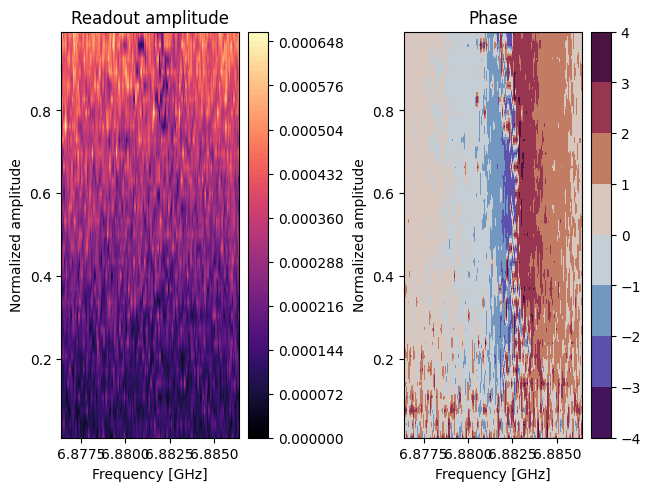

In [1098]:
# plot the results
lo_freq = measure_q.parameters.readout_lo_frequency
spec_freq = lo_freq + spec_amp_results.get_axis("res_spec_pulsed")[1]
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

X, Y = np.meshgrid(spec_freq, amp)
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
CS = ax[0].contourf(X / 1e9, Y, np.abs(data), levels=100, cmap="magma")
ax[0].set_title("Readout amplitude")
ax[0].set_xlabel("Frequency [GHz]")
ax[0].set_ylabel("Normalized amplitude")
fig.colorbar(CS)

max_value = (
    max(
        # int(np.abs(np.min(np.unwrap(np.angle(data, deg=False))))),
        # int(np.abs(np.max(np.unwrap(np.angle(data, deg=False))))),
        int(np.abs(np.min(np.angle(data, deg=False)))),
        int(np.abs(np.max(np.angle(data, deg=False)))),
    )
    + 1
)

cs2_levels = np.linspace(-max_value, max_value, 2 * (max_value) + 1)

CS2 = ax[1].contourf(
    X / 1e9,
    Y,
    # np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data)),
    np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data),
    levels=cs2_levels,
    cmap="twilight_shifted",
)
ax[1].set_title("Phase")
ax[1].set_xlabel("Frequency [GHz]")
ax[1].set_ylabel("Normalized amplitude")
fig.colorbar(CS2)

In [1099]:
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_47976\828720308.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, [ax1, ax2] = plt.subplots(2, 1)


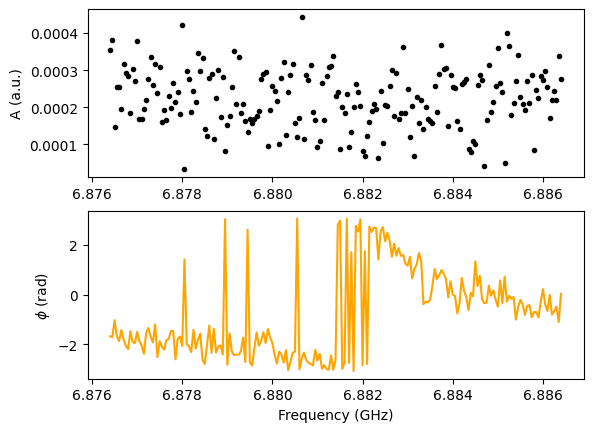

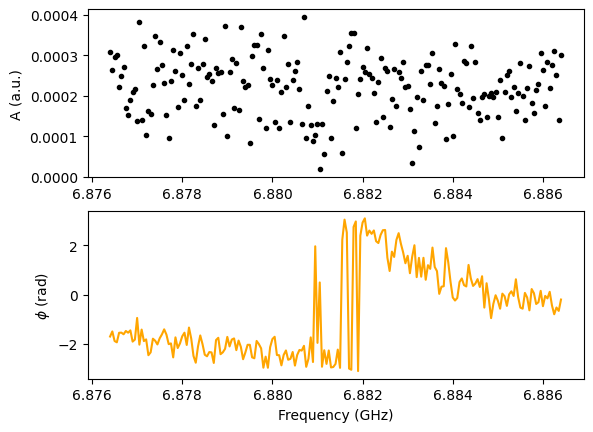

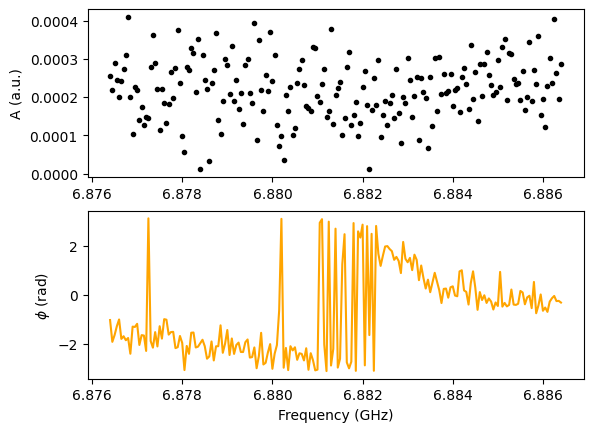

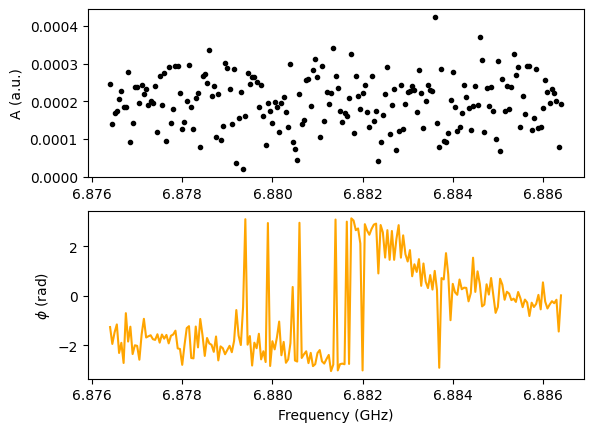

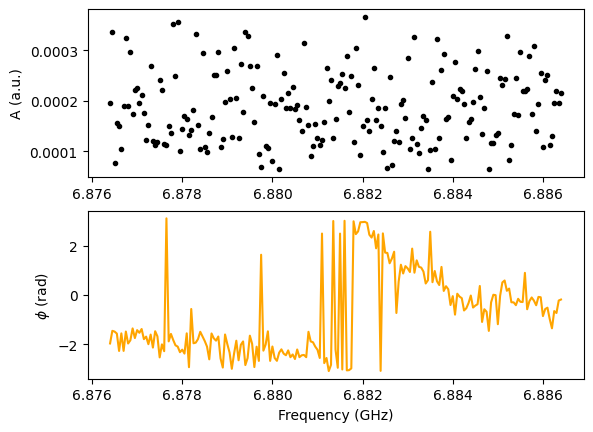

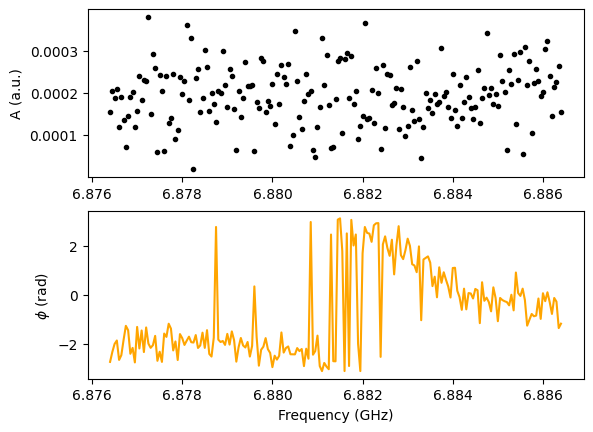

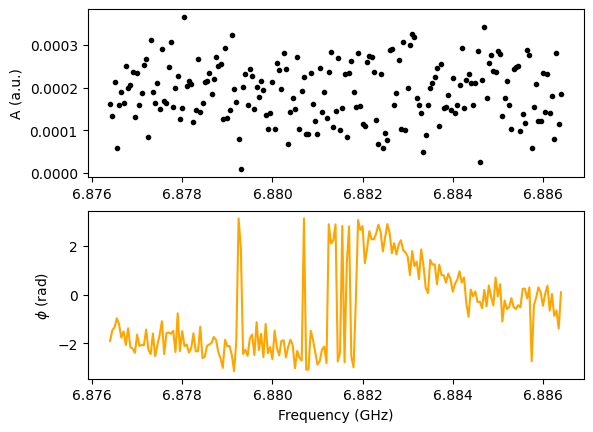

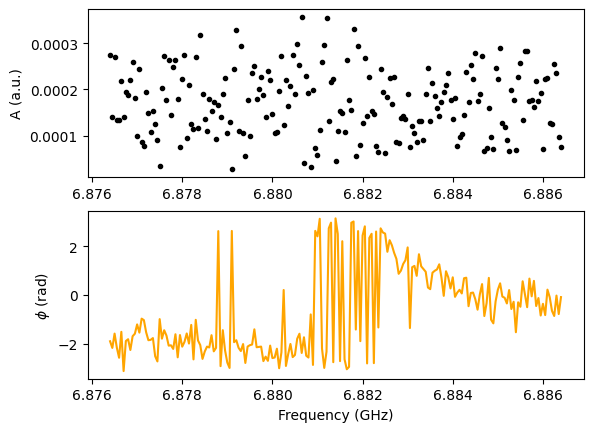

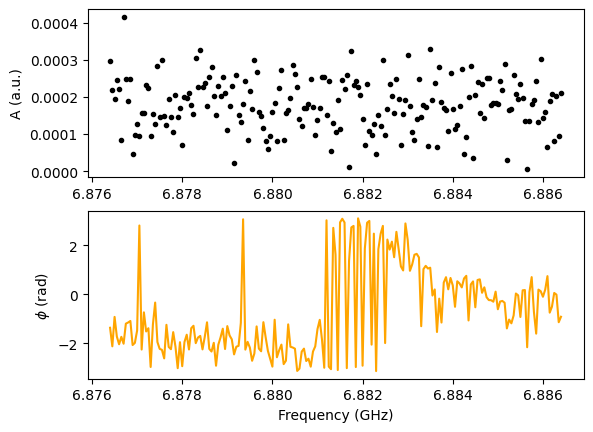

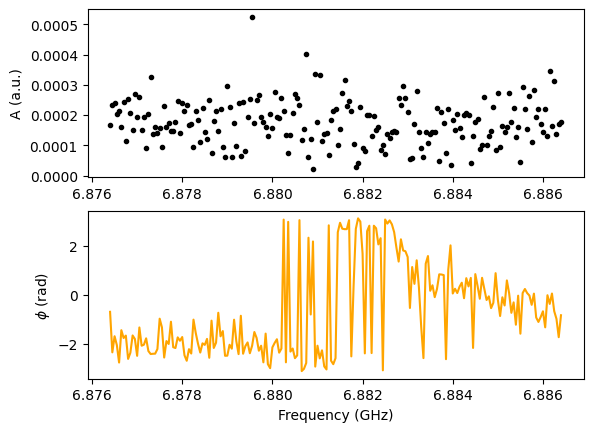

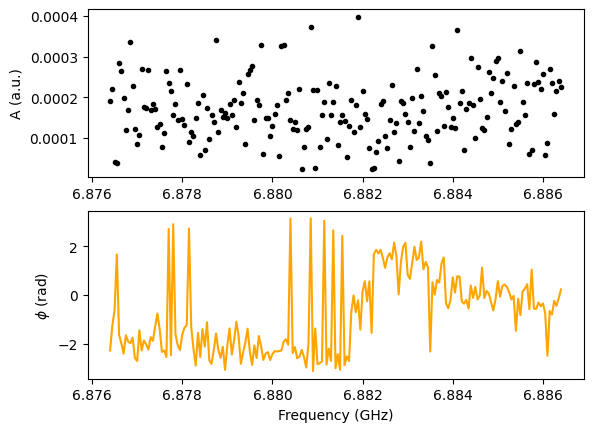

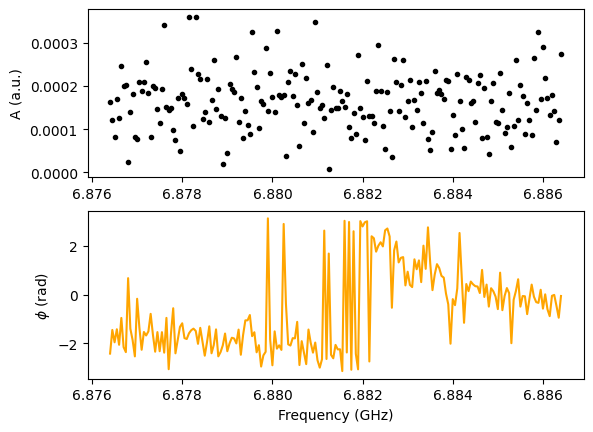

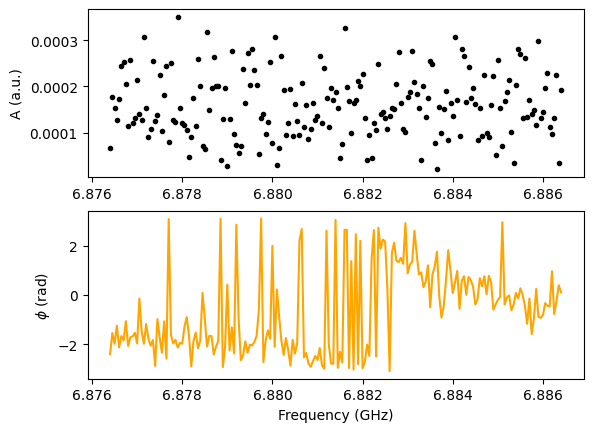

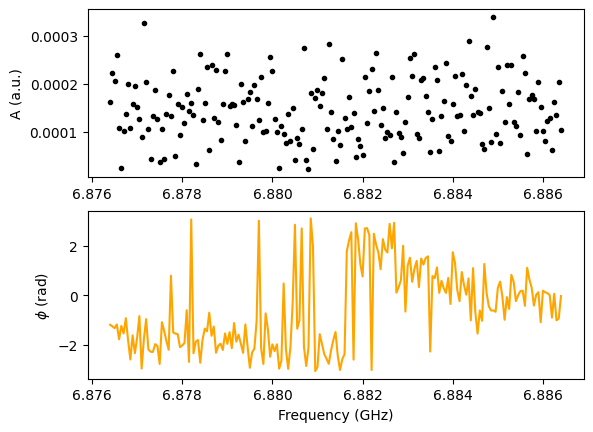

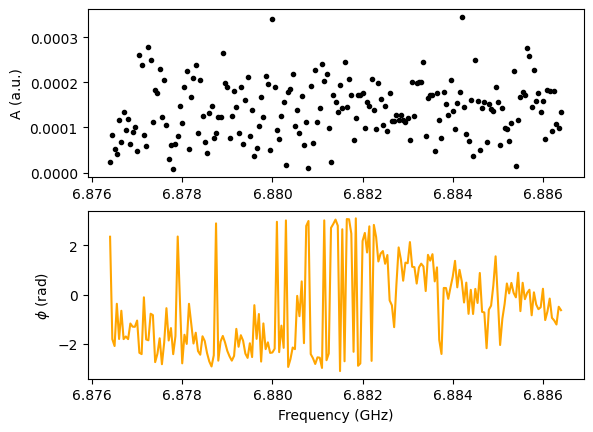

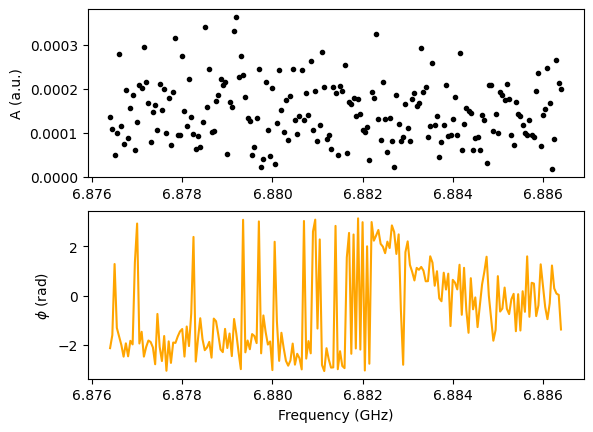

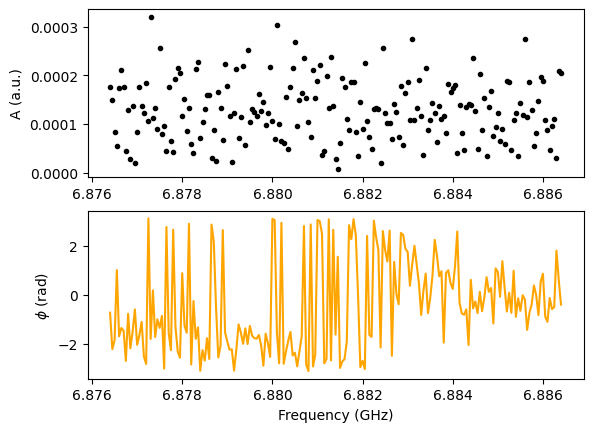

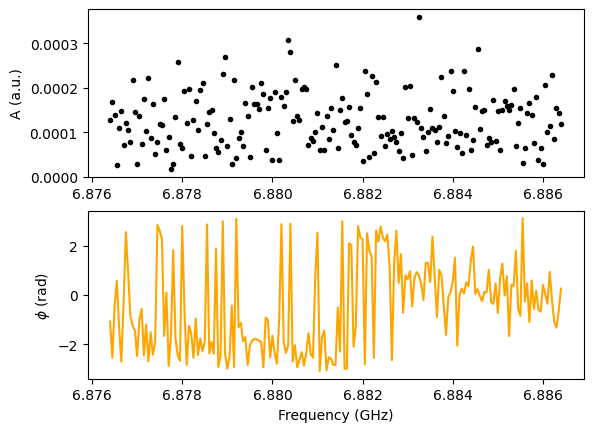

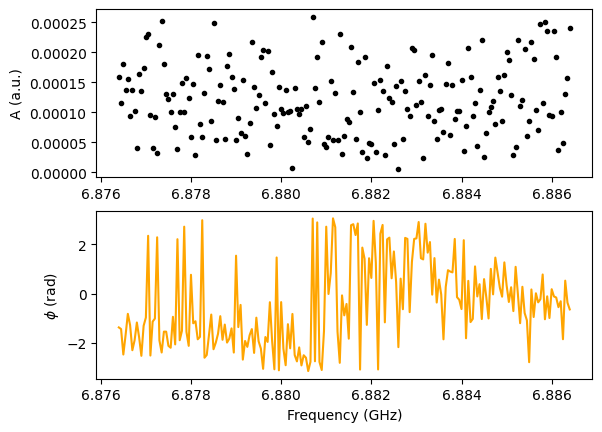

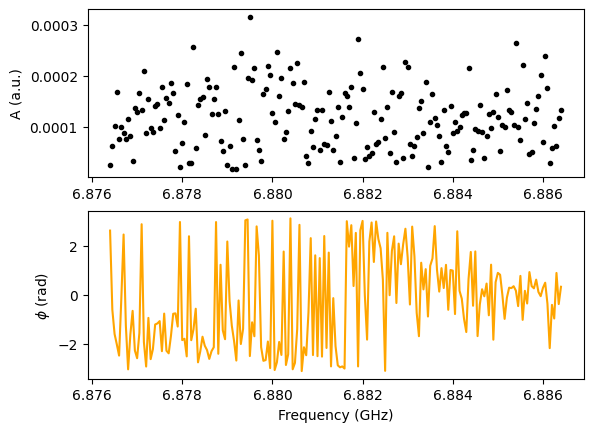

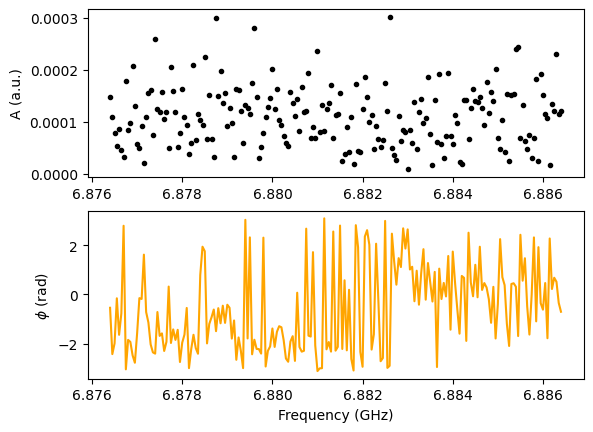

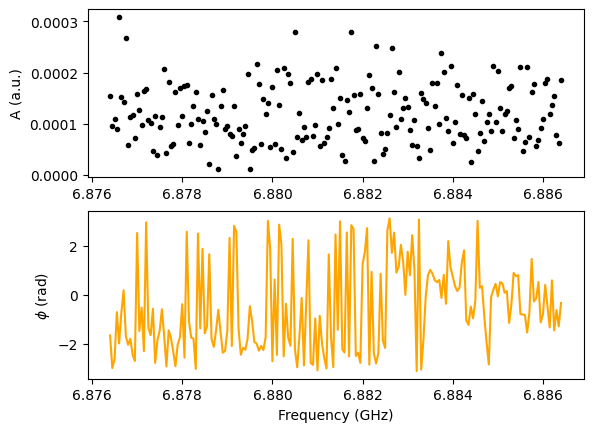

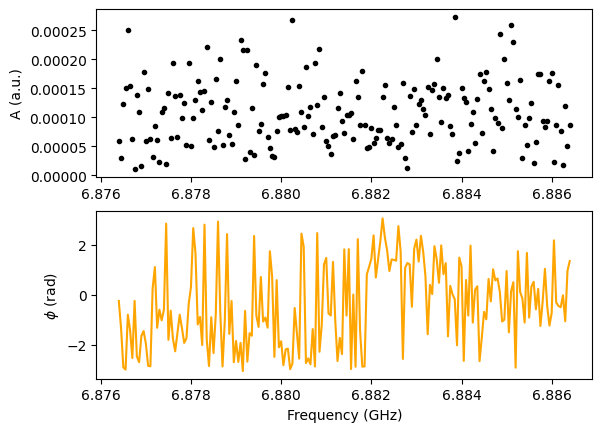

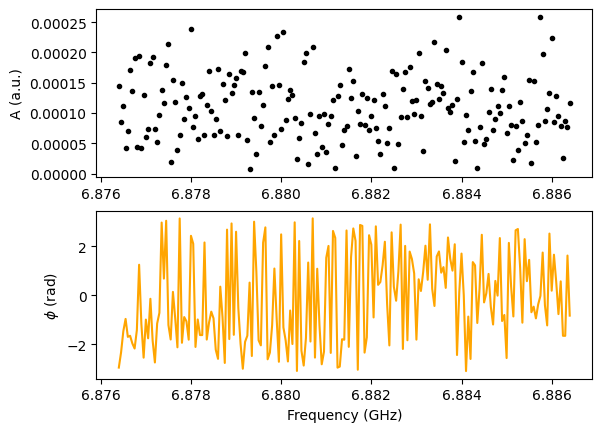

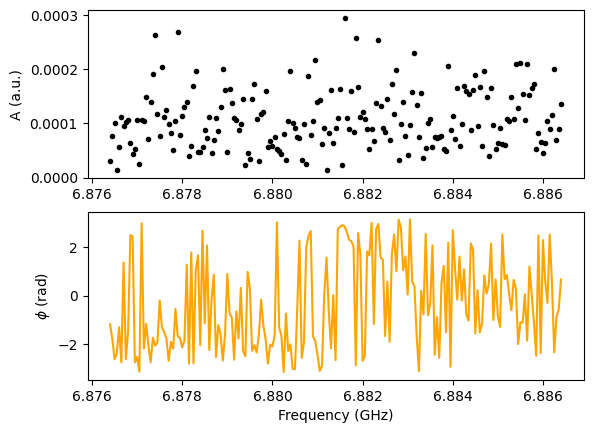

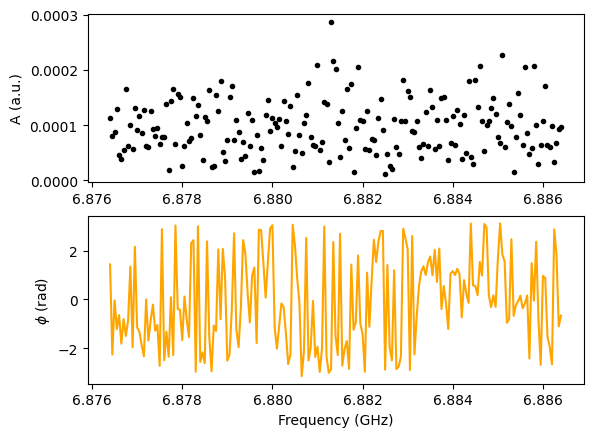

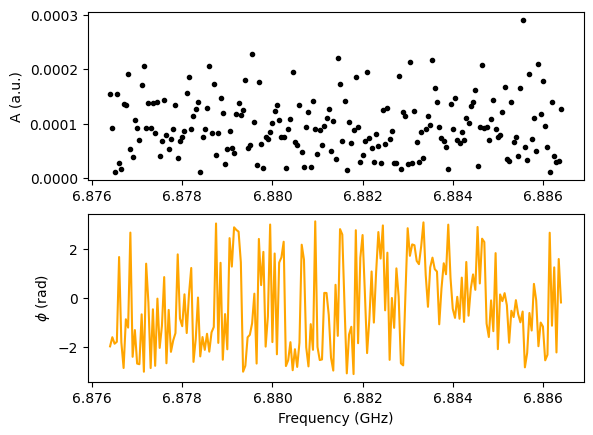

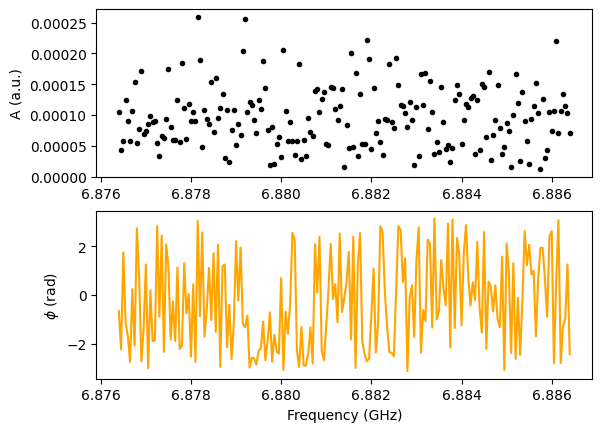

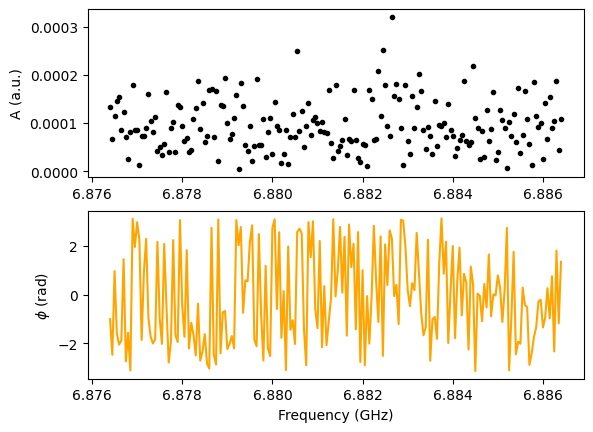

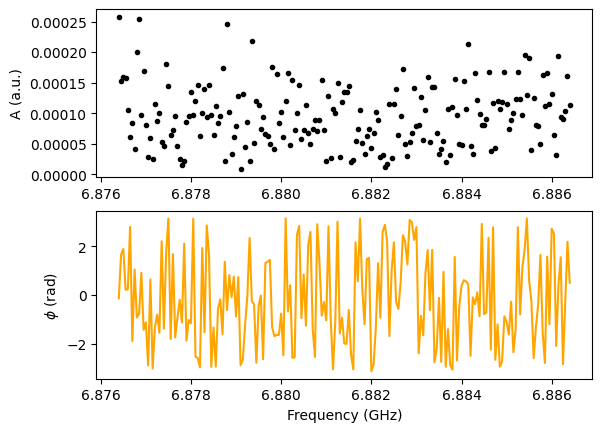

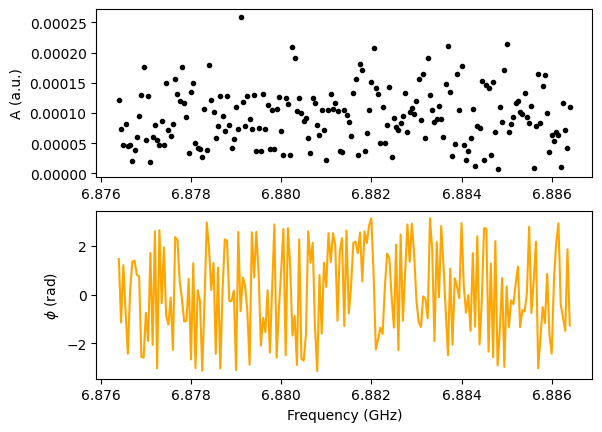

In [1081]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_amp_results.get_data("res_spec_pulsed")
spec_freq = (
    measure_q.parameters.readout_lo_frequency + spec_amp_results.get_axis("res_spec_pulsed")[0]
)
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

np.shape(spec_res)
np.shape(spec_freq)
np.shape(data)

for d in np.flip(data, axis=0):
# for d in data:
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = d
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_amp_results.get_axis("res_spec_pulsed")[1]
    )

    emulate=False
    if emulate:
        # create some dummy data if running in emulation mode
        spec_res = lorentzian(
            spec_freq,
            10e6,
            measure_q.parameters.readout_resonator_frequency * (0.995 + 0.01 * np.random.rand(1)[0]),
            -2e6,
            1,
        ) + 0.1 * np.random.rand(len(spec_freq))
    
    # plot the measurement data
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
    ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
    ax1.set_ylabel("A (a.u.)")
    ax2.set_ylabel("$\\phi$ (rad)")
    ax2.set_xlabel("Frequency (GHz)")
    # ax2.axvline(spec_freq[np.argmin(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res))]/1e9)
    # spec_freq[np.argmin(abs(spec_res))]/1e9

Text(0.5, 1.0, 'Punchout phase')

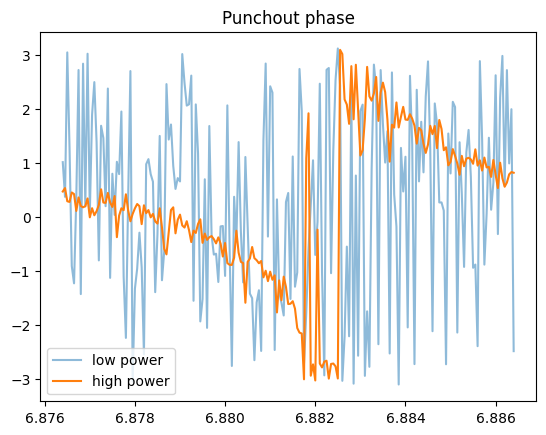

In [1101]:
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")
electrical_delay = 45.68e-9
alpha=0.5
# plt.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*(data[2]))), label='low power', alpha=alpha)
# plt.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*(data[-1]))), label='high power', alpha=1)
plt.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*(data[2])), label='low power', alpha=alpha)
plt.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*(data[-1])), label='high power', alpha=1)
plt.legend()
plt.title('Punchout phase')

In [1113]:
measure_q.parameters.user_defined['readout_range_out'] = -15
measure_q.parameters.user_defined['readout_range_in'] = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.15
measure_q.parameters.user_defined['readout_amp'] = 0.05
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=900000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1200000000.0,
│   │   readout_resonator_frequency=6881400000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [1114]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=900000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1200000000.0,
│   │   readout_resonator_frequency=6881400000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

## Resonator vs flux 

### resonator spectroscopy setup

In [1115]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -10e6
stop_freq = 10e6
num_points = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

readout_pulse = create_readout_pulse(measure_q)

In [1116]:
2**10

1024

In [1117]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=900000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1200000000.0,
│   │   readout_resonator_frequency=6881400000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

#### 3.2.2 Experiment Definition

In [1118]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [1119]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [1120]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [1121]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.30 10:17:21.995] INFO    Starting LabOne Q Compiler run...
[2024.07.30 10:17:22.009] INFO    Schedule completed. [0.008 s]
[2024.07.30 10:17:22.038] INFO    Code generation completed for all AWGs. [0.024 s]
[2024.07.30 10:17:22.042] INFO    Completed compilation step 1 of 1. [0.040 s]
[2024.07.30 10:17:22.047] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 10:17:22.051] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 10:17:22.055] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 10:17:22.059] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.30 10:17:22.063] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 10:17:22.066] INFO      TOTAL                      23            0                  8000  
[2024.07.30 10:17:22.069] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-30-10-17-22.html

#### 3.2.4 Run and Evaluate Experiment

In [1122]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.30 10:17:22.239] INFO    Configuring the device setup
[2024.07.30 10:17:22.358] INFO    The device setup is configured
[2024.07.30 10:17:23.531] INFO    Starting near-time execution...
[2024.07.30 10:17:25.253] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T101725.json


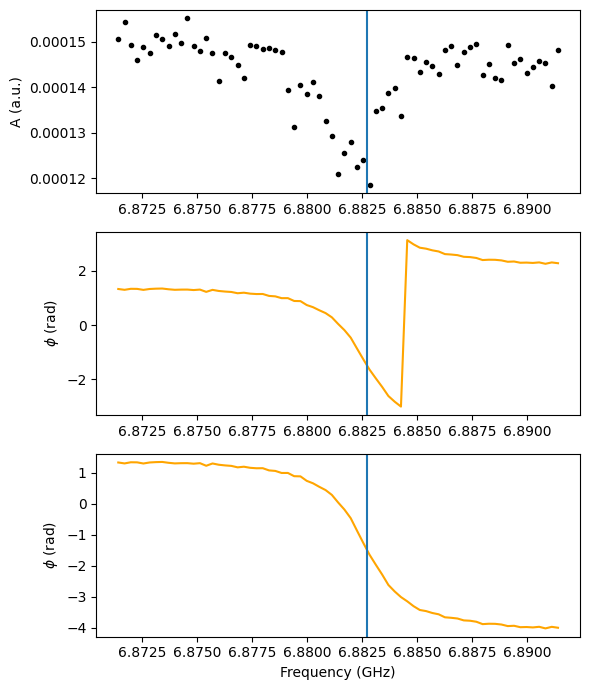

In [1123]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.8827]
for _vl in vl:
    ax1.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax2.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax3.axvline(_vl, ls='-', 
                # color='tab:blue',
               )

plt.tight_layout()
plt.show()

### f_r vs phi ext

In [365]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.02s


KeyError: 'Another instrument has the name: yoko'

In [237]:
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [238]:
dc.output('off')
dc.source_mode('CURR')

In [239]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

In [1007]:
import sys

In [1124]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)

start_curr = 0.15e-3
stop_curr = 0.225e-3
current_sweep = np.linspace(start_curr,stop_curr, 101)

dc.ramp_current(0e-3, 1e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

# dc.ramp_current(0,0.5e-6,0)
# dc.output('off')

step 0
current: 0.00015
[2024.07.30 10:18:15.289] INFO    Configuring the device setup
[2024.07.30 10:18:15.401] INFO    The device setup is configured
[2024.07.30 10:18:16.672] INFO    Starting near-time execution...
[2024.07.30 10:18:18.227] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T101818.json
step 1
current: 0.00015074999999999998
[2024.07.30 10:18:19.990] INFO    Starting near-time execution...
[2024.07.30 10:18:21.779] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T101821.json
step 2
current: 0.0001515
[2024.07.30 10:18:23.840] INFO    Starting near-time execution...
[2024.07.30 10:18:25.487] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T101825.json
step 3
current: 0.00015225
[2024.07.30 10:18:26.653] INFO    Starting near-time execution...
[2024.07.30 10:18:28.299] INFO    Finished near-time execution.
File saved as Results_Need

Text(0.5, 1.0, 'LogMag [arb.]')

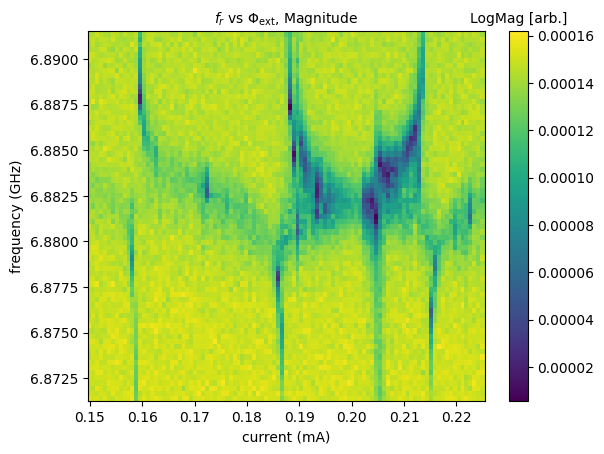

In [1128]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

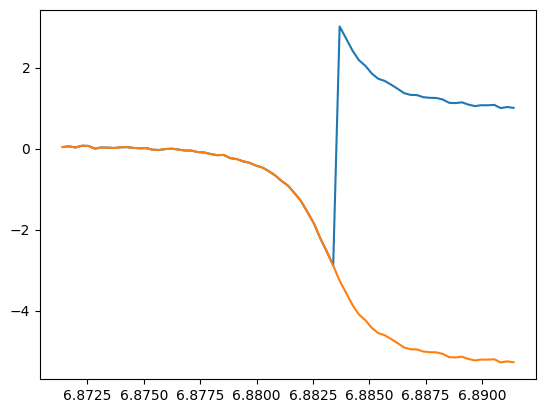

In [1129]:
electrical_delay = 60.65e-9
plt.plot(spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results[0]).T)
plt.plot(spec_freq/1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results[0]).T))

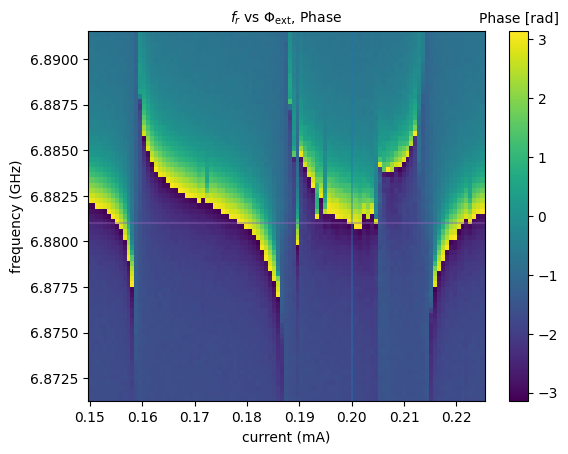

In [1133]:
electrical_delay = 60.61e-9
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.2, c='tab:blue', alpha=0.4)
plt.axhline(6.881, c='tab:purple', alpha=0.4)

# Two-tone

In [1415]:
dc.ramp_current(0.201e-3, 0.1e-6, 0)

In [1416]:
dc.output('on')

In [1417]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
# qspec_num = 1001
qspec_num = 401

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

In [1418]:
measure_q?

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=977580000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-30,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.05,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

In [1419]:
### QB spec
measure_q.parameters.drive_lo_frequency = 1.3e9

LF_path = False
start_freq = 50e6
stop_freq = -50e6
measure_q.parameters.resonance_frequency_ge = 0.97758e9
# measure_q.parameters.user_defined['amplitude_pi'] = 0.99
measure_q.parameters.user_defined['amplitude_pi'] = 0.05

### RO spec
measure_q.parameters.readout_resonator_frequency = 6.881e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3


# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

# measure_q.parameters.drive_range = 5
measure_q.parameters.drive_range = -30
measure_q.parameters.user_defined['reset_length'] = 1e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 2000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=977580000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-30,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.05,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [1420]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [1421]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [1422]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [1423]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [1424]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(1e-06,
 LinearSweepParameter(uid='drive_freq_q0', start=-272420000.0, stop=-372420000.0, count=401, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q0', amplitude=0.95, length=2e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q0', amplitude=0.05, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [1425]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.30 11:28:06.579] INFO    Starting LabOne Q Compiler run...
[2024.07.30 11:28:06.621] INFO    Schedule completed. [0.040 s]
[2024.07.30 11:28:07.298] INFO    Code generation completed for all AWGs. [0.675 s]
[2024.07.30 11:28:07.300] INFO    Completed compilation step 1 of 1. [0.719 s]
[2024.07.30 11:28:07.303] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:28:07.305] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 11:28:07.306] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:28:07.307] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.30 11:28:07.309] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.30 11:28:07.310] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:28:07.312] INFO      TOTAL                         32 

In [1426]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.30 11:28:07.322] INFO    Configuring the device setup
[2024.07.30 11:28:07.435] INFO    The device setup is configured
[2024.07.30 11:28:08.594] INFO    Starting near-time execution...
[2024.07.30 11:28:09.129] INFO    Estimated RT execution time: 8.36 s.
[2024.07.30 11:28:17.757] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T112817.json


In [1427]:
emulate=False

estimated frequency 0.96733 GHz


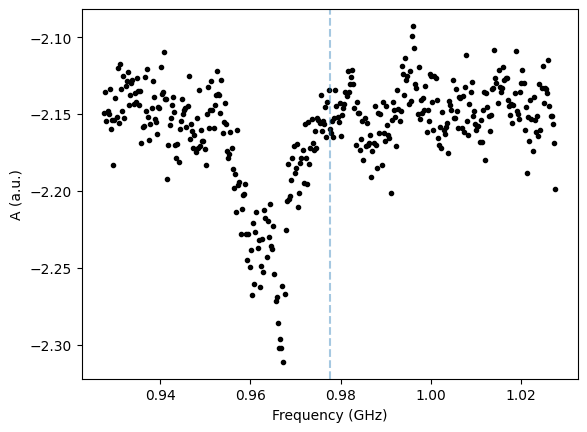

In [1428]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

plt.axvline(0.97758, linestyle = '--', alpha=0.4)
# plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

In [1363]:
measure_q.parameters.resonance_frequency_ge = 0.97758e9
device_setup.set_calibration(
    measure_q.calibration()
)

## Two-tone vs flux
Fine two tone sweep to find half-flux

[2024.07.30 11:34:37.964] INFO    Starting near-time execution...
[2024.07.30 11:34:38.532] INFO    Estimated RT execution time: 8.36 s.
[2024.07.30 11:34:47.217] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T113447.json
[2024.07.30 11:34:49.074] INFO    Starting near-time execution...
[2024.07.30 11:34:49.618] INFO    Estimated RT execution time: 8.36 s.
[2024.07.30 11:34:58.209] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T113458.json
[2024.07.30 11:35:00.194] INFO    Starting near-time execution...
[2024.07.30 11:35:00.679] INFO    Estimated RT execution time: 8.36 s.
[2024.07.30 11:35:09.374] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T113509.json
[2024.07.30 11:35:11.182] INFO    Starting near-time execution...
[2024.07.30 11:35:11.737] INFO    Estimated RT execution time: 8.36 s.
[2024.07.30 11:35:20.343] INFO    Finished near-time execution.
File

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_47976\285051226.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


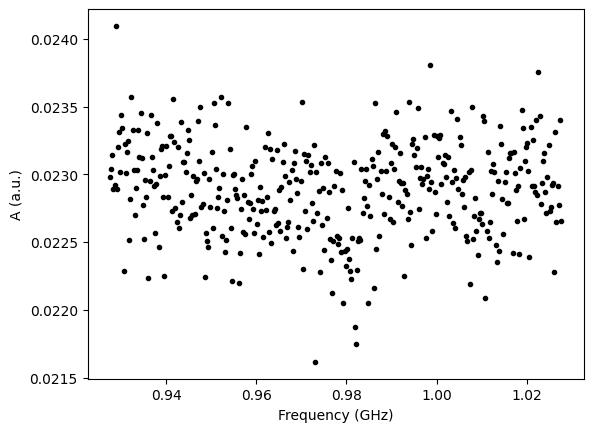

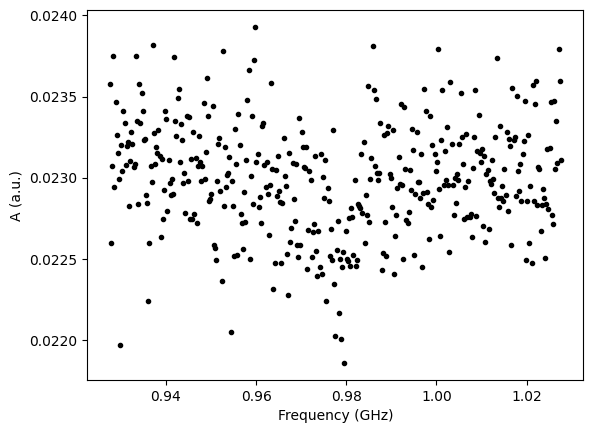

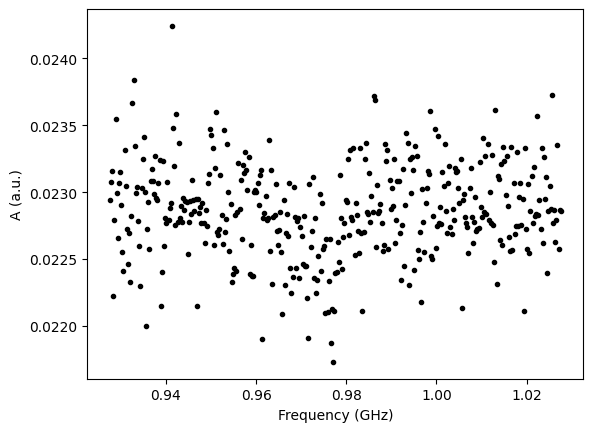

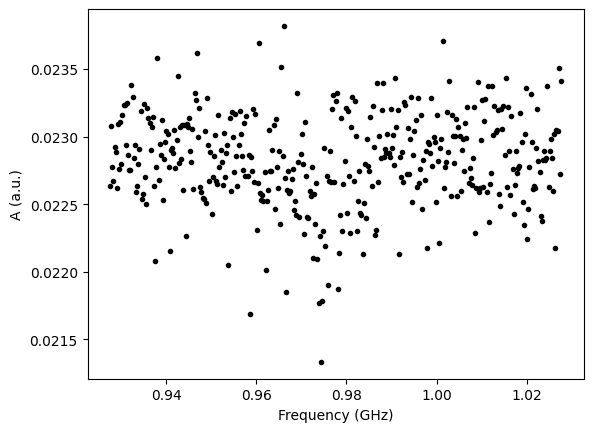

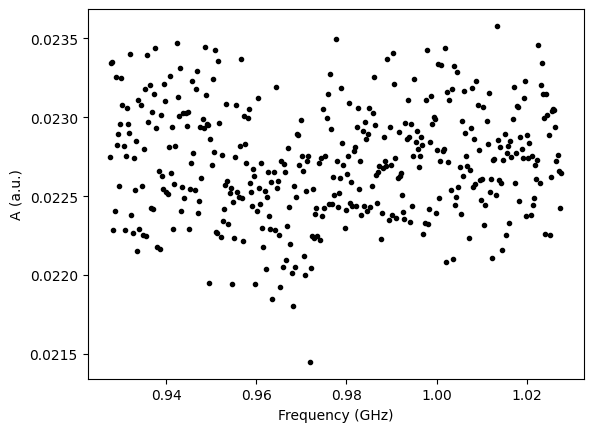

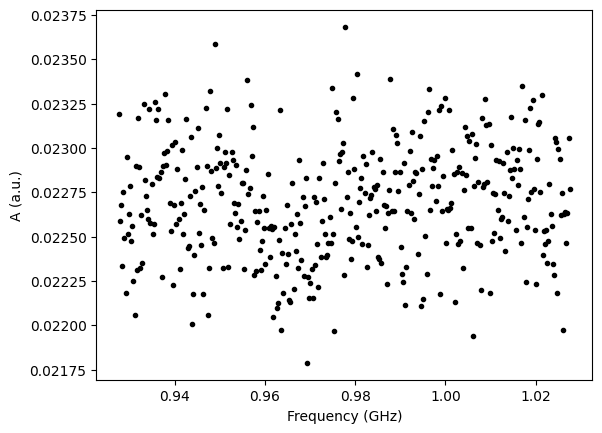

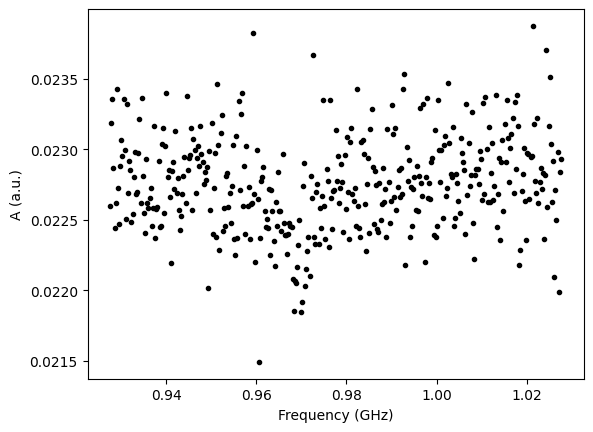

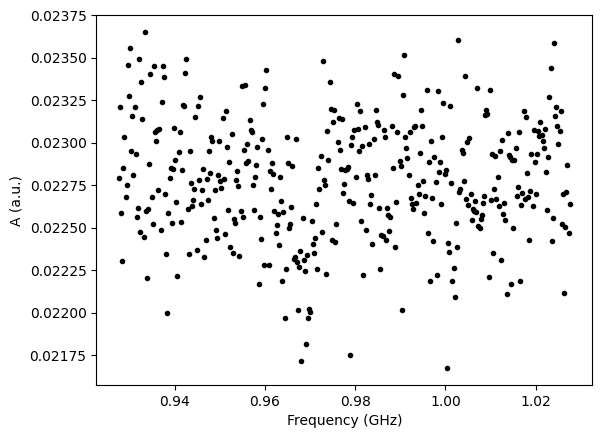

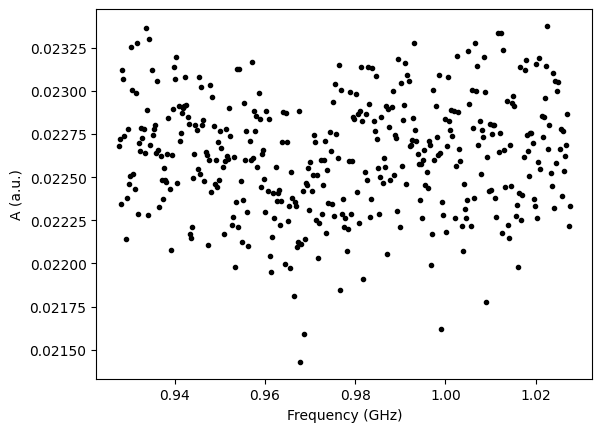

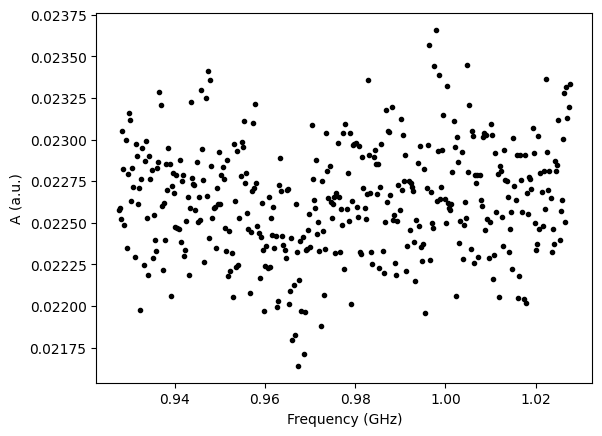

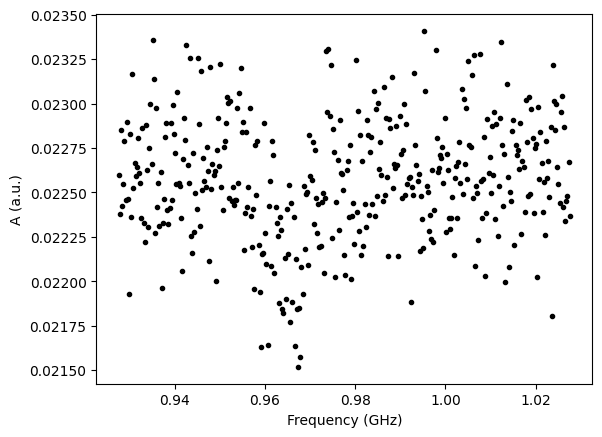

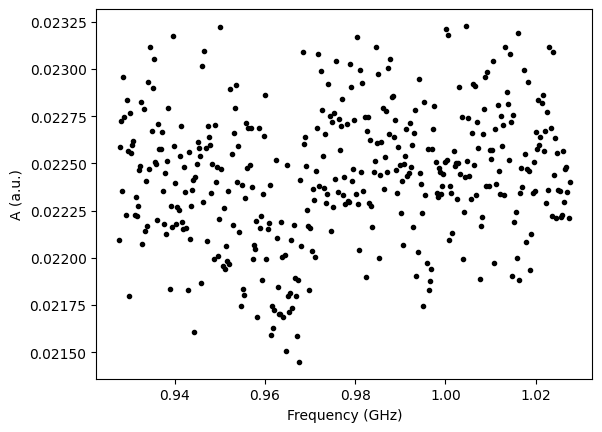

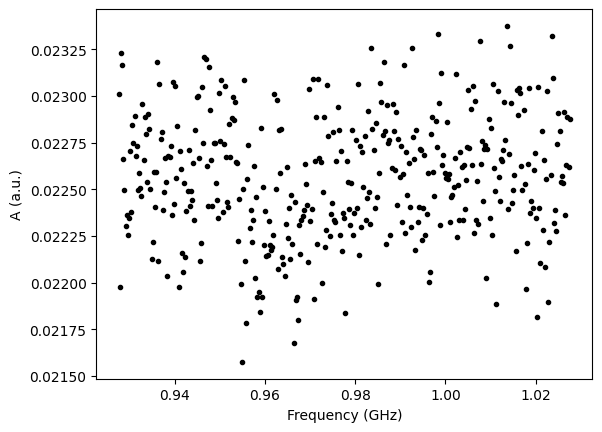

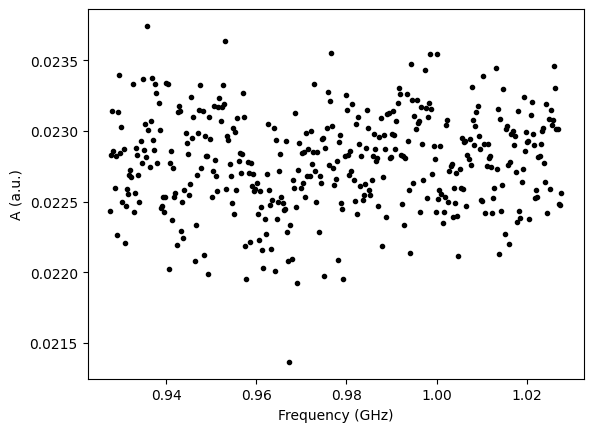

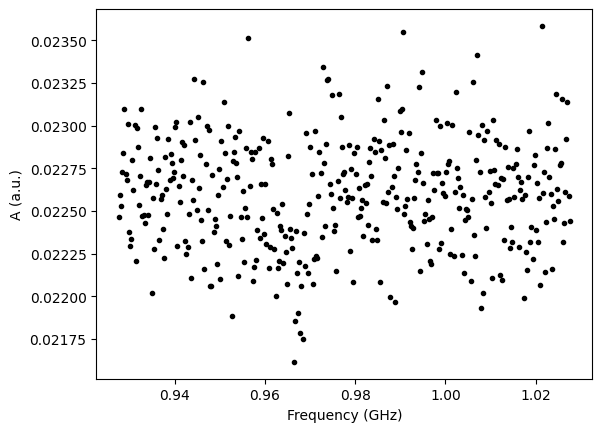

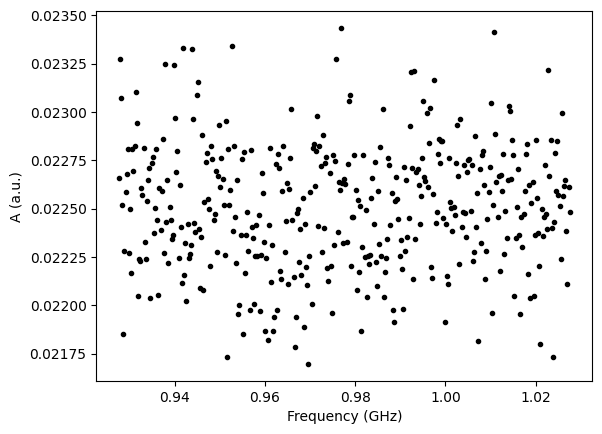

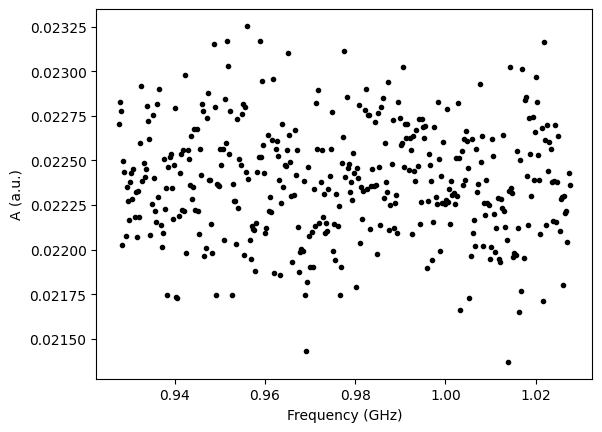

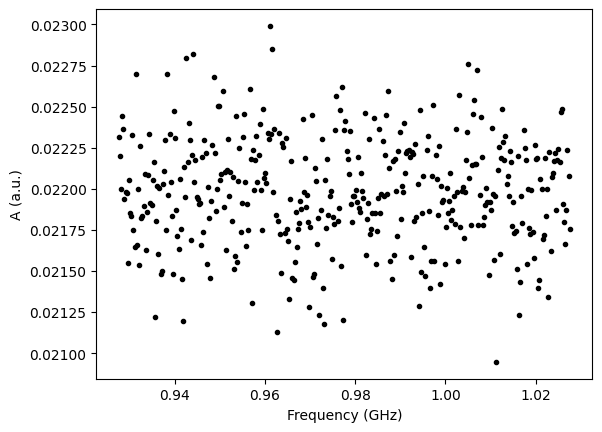

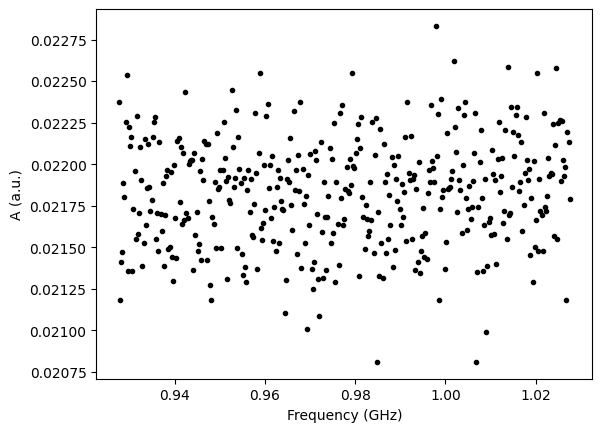

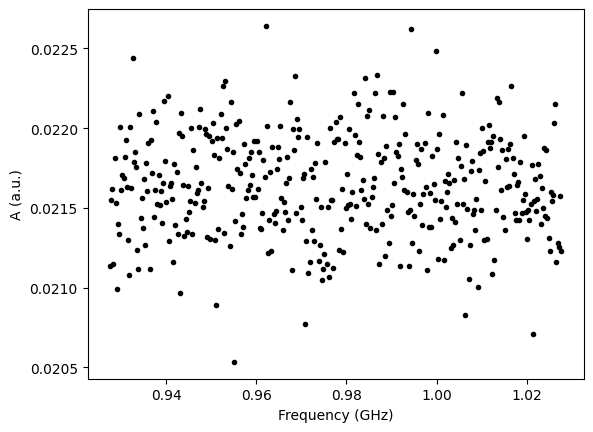

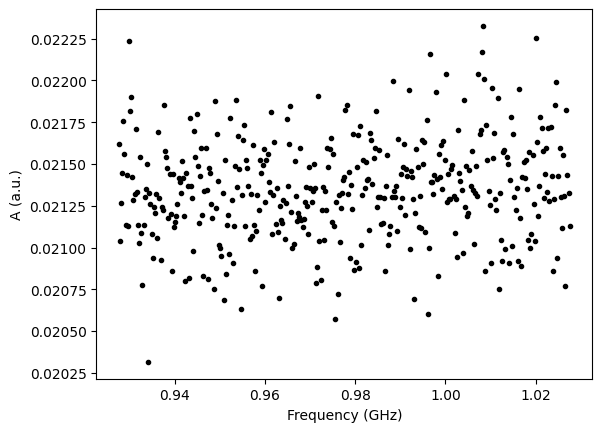

In [1431]:
dc.current_range(1e-3)
start = 0.200e-3
stop = 0.202e-3

current_sweep = np.linspace(start, stop, 21)
dc.output('on')
sweep_qspec_results = []
for current in current_sweep:
    dc.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)
    # run the experiment on qubit 0
    qspec_results = session.run()

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    sweep_qspec_results.append(qspec_res)

    # plot measurement data
    fig = plt.figure()
    plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
    plt.ylabel("A (a.u.)")
    plt.xlabel("Frequency (GHz)")

# plt.show()
# dc.ramp_current(5.5e-3,1e-5,0)

Text(0.5, 1.0, 'mag')

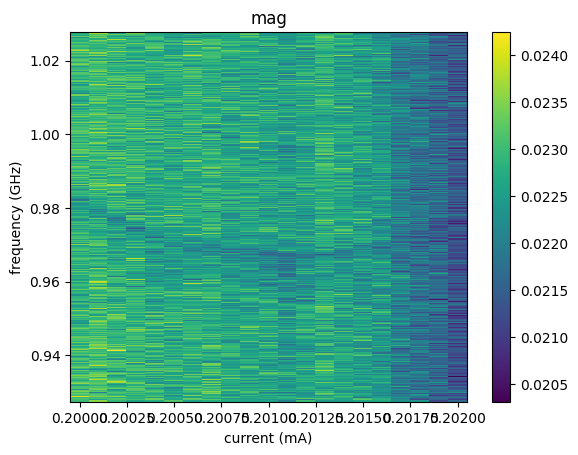

In [1432]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

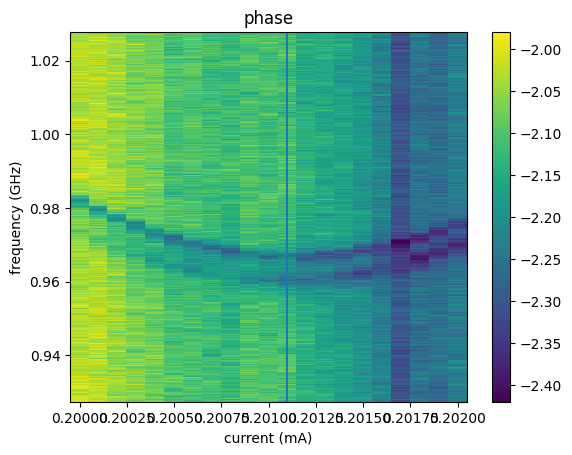

In [1439]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.angle(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
plt.axvline(0.2011)
# current_sweep[8]*1e3

(0.96, 0.97)

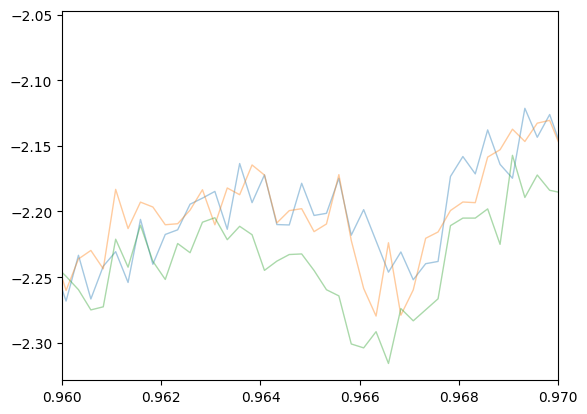

In [1462]:
plt.plot(qspec_freq/1e9, angle_data[:, 11], lw=1, alpha=0.4)
plt.plot(qspec_freq/1e9, angle_data[:, 10], lw=1, alpha=0.4)
plt.plot(qspec_freq/1e9, angle_data[:, 12], lw=1, alpha=0.4)
plt.xlim(0.96, 0.97)

In [1440]:
angle_data = np.angle(sweep_qspec_results).T
angle_data.shape

(401, 21)

In [1447]:
min_arr = np.argmin(angle_data, axis=0)
min_arr.shape

(21,)

In [1450]:
min_freqs = (qspec_freq/1e9)[min_arr]
min_freqs.shape

(21,)

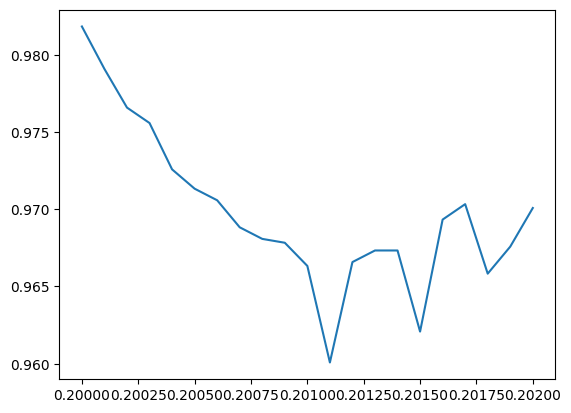

In [1451]:
# plt.plot( current_sweep*1e3, min_arr)
plt.plot( current_sweep*1e3, min_freqs)

### 3.6 Amplitude Rabi Experiment

Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles

#### 3.6.1 Additional Experimental Parameters

Define the amplitude sweep range and qubit excitation pulse

In [1499]:
dc.ramp_current(0.2011e-3, 1e-6, 0)

In [1500]:
measure_q.parameters.resonance_frequency_ge = 0.967e9
# measure_q.parameters.user_defined['pulse_length'] = 50e-9
measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [1501]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 20
amp_min=0.0
amp_max=0.99


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [1502]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [1503]:
def create_rabi_amp_sweep(qubit, amp_num, amp_min=0.1, amp_max=0.22, uid="rabi_amp"):
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

In [1504]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes, amp_min=amp_min, amp_max=amp_max), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.07.30 12:03:35.989] INFO    Starting LabOne Q Compiler run...
[2024.07.30 12:03:36.000] INFO    Schedule completed. [0.006 s]
[2024.07.30 12:03:36.040] INFO    Code generation completed for all AWGs. [0.039 s]
[2024.07.30 12:03:36.043] INFO    Completed compilation step 1 of 1. [0.049 s]
[2024.07.30 12:03:36.048] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 12:03:36.050] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 12:03:36.052] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 12:03:36.053] INFO      device_shfqc        0         11            0           1      8000  
[2024.07.30 12:03:36.054] INFO      device_shfqc_sg     0         71           20           2     16000  
[2024.07.30 12:03:36.056] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 12:03:36.057] INFO      TOTAL                         82 

#### 3.6.4 Show Pulse Sheet

In [1505]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.07.30 12:03:41.028] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 12:03:41.032] INFO    Starting LabOne Q Compiler run...
[2024.07.30 12:03:41.040] INFO    Schedule completed. [0.005 s]
[2024.07.30 12:03:41.078] INFO    Code generation completed for all AWGs. [0.036 s]
[2024.07.30 12:03:41.081] INFO    Completed compilation step 1 of 1. [0.045 s]
[2024.07.30 12:03:41.082] INFO    Finished LabOne Q Compiler run.
[2024.07.30 12:03:41.096] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-12-03-41.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-12-03-41.html

#### 3.6.5 Plot Simulated Outputs

In [1506]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [1507]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.07.30 12:04:36.588] INFO    Configuring the device setup
[2024.07.30 12:04:36.705] INFO    The device setup is configured
[2024.07.30 12:04:37.789] INFO    Starting near-time execution...
[2024.07.30 12:04:38.345] INFO    Estimated RT execution time: 17.04 s.
[2024.07.30 12:04:55.620] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240730T120455.json


In [1508]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = oscillatory(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(
        len(rabi_amp)
    )

Fitted parameters: [ 5.20886937e+00  3.27846558e+00 -2.33038825e-03 -1.50571197e-02]


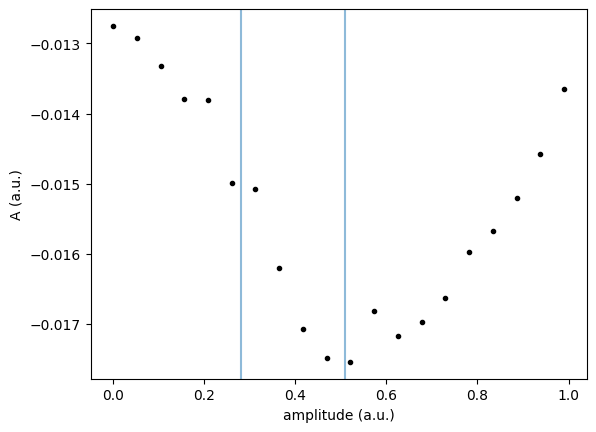

In [1523]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
plt.axvline(0.51, alpha=0.5)
plt.axvline(0.28, alpha=0.5)
# pi_amp = 0.95

In [1519]:
# rabi_amplitude = pi_amp
measure_q.parameters.user_defined['amplitude_pi'] = 0.51

# T1

#### 3.7.1 Experiment Parameters

In [1487]:
# measure_q.parameters.user_defined['amplitude_pi'] = 0.95
# measure_q.parameters.user_defined['pulse_length'] = 20e-6
# measure_q.parameters.drive_range = 10

In [1488]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-30,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [1489]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 40
start_delay = 0e-6
stop_delay = 200e-6


#### 3.7.2 Experiment Definition

In [1490]:
# function that returns a T1 experiment


def T1(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_T1 = Experiment(
        uid="T1 Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define T1 experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_T1.acquire_loop_rt(
        uid="T1_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        
        # inner loop - real time sweep of T1 time delays
        with exp_T1.sweep(
            uid="T1_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - delay is swept
            with exp_T1.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_T1.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_T1.delay(signal="drive", time=time_sweep)
            # readout pulse and data acquisition
            with exp_T1.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_T1.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_T1.acquire(
                    signal="acquire",
                    handle="T1",
                    kernel=readout_pulse,
                )
            with exp_T1.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_T1.reserve(signal="measure")
    return exp_T1

#### 3.7.3 Create Experiment and Signal Map

In [1491]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_T1_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

T1_exp = T1(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

T1_exp.set_signal_map(signal_map_default(measure_q))

compiled_T1 = session.compile(T1_exp)

[2024.07.30 11:53:20.776] INFO    Starting LabOne Q Compiler run...
[2024.07.30 11:53:20.784] INFO    Schedule completed. [0.005 s]
[2024.07.30 11:53:20.819] INFO    Code generation completed for all AWGs. [0.034 s]
[2024.07.30 11:53:20.821] INFO    Completed compilation step 1 of 1. [0.042 s]
[2024.07.30 11:53:20.824] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:53:20.825] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 11:53:20.827] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:53:20.828] INFO      device_shfqc        0        221            0           1      8000  
[2024.07.30 11:53:20.829] INFO      device_shfqc_sg     0        241           16          16    128480  
[2024.07.30 11:53:20.830] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:53:20.831] INFO      TOTAL                        462 

#### 3.7.4 Show Pulse Sheet

In [1492]:
show_pulse_sheet("Pulse_Sheets/T1", compiled_T1)

[2024.07.30 11:53:40.800] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 11:53:40.804] INFO    Starting LabOne Q Compiler run...
[2024.07.30 11:53:40.814] INFO    Schedule completed. [0.008 s]
[2024.07.30 11:53:40.850] INFO    Code generation completed for all AWGs. [0.035 s]
[2024.07.30 11:53:40.851] INFO    Completed compilation step 1 of 1. [0.045 s]
[2024.07.30 11:53:40.853] INFO    Finished LabOne Q Compiler run.
[2024.07.30 11:53:40.866] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-07-30-11-53-40.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-07-30-11-53-40.html

#### 3.7.5 Plot Simulated Outputs

In [1493]:
# plot_simulation(compiled_T1, 100e-6, 150e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [1494]:
# run the compiled experiemnt
T1_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/T1_results_{timestamp}.json")
print(f"File saved as Results_Needed/T1_results_{timestamp}.json")

[2024.07.30 11:53:40.905] INFO    Configuring the device setup
[2024.07.30 11:53:41.015] INFO    The device setup is configured
[2024.07.30 11:53:42.106] INFO    Starting near-time execution...
[2024.07.30 11:53:42.621] INFO    Estimated RT execution time: 66.85 s.
[2024.07.30 11:54:49.698] INFO    Finished near-time execution.
File saved as Results_Needed/T1_results_20240730T115449.json


In [1495]:
# get measurement data returned by the instruments
T1_res = T1_results.get_data("T1")

# define time axis from qubit parameters
T1_delay = T1_results.get_axis("T1")[0]

if emulate:
    # create dummy data if running in emulation mode
    T1_res = exponential_decay(
        T1_delay, 2e5, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(T1_delay))

Text(0.5, 0, 'delay (us)')

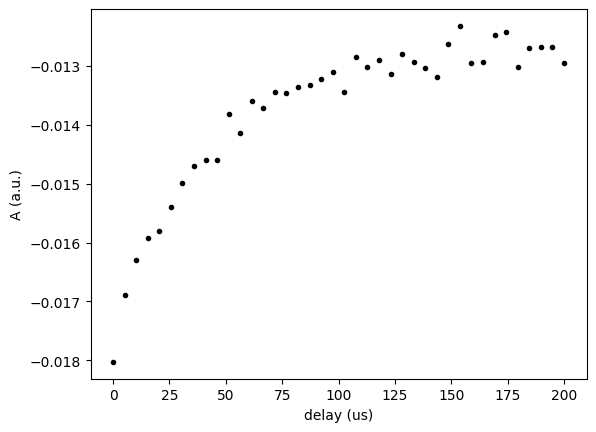

In [1496]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay*1e6, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

Fitted parameters: [ 2.46558802e+04 -1.26992135e-02 -4.97130028e-03]
T1 time 40.558276198162396 us


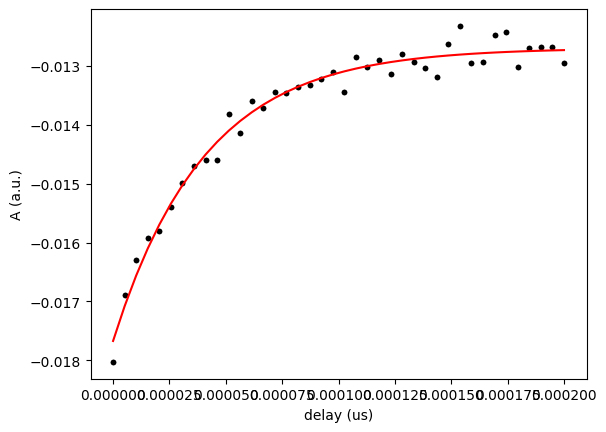

In [1497]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

# increase number of plot points for smooth plotting of fit results
#delay_plot = np.linspace(T1_delay[0], T1_delay[-1], 5 * len(T1_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = exponential_decay.fit(
   T1_delay,
   T1_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 
# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

# Single-qubit gates

In [1498]:
measure_q.parameters.drive_range = -25

device_setup.set_calibration(
    measure_q.calibration()
)

In [1476]:
measure_q.parameters.resonance_frequency_ge = 0.967e9
measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-30,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [1477]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 20
amp_min=0.0
amp_max=0.99


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [1478]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [1479]:
def create_rabi_amp_sweep(qubit, amp_num, amp_min=0.1, amp_max=0.22, uid="rabi_amp"):
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

In [1480]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes, amp_min=amp_min, amp_max=amp_max), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.07.30 11:52:31.766] INFO    Starting LabOne Q Compiler run...
[2024.07.30 11:52:31.771] INFO    Schedule completed. [0.002 s]
[2024.07.30 11:52:31.798] INFO    Code generation completed for all AWGs. [0.026 s]
[2024.07.30 11:52:31.800] INFO    Completed compilation step 1 of 1. [0.032 s]
[2024.07.30 11:52:31.806] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:52:31.808] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 11:52:31.809] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:52:31.810] INFO      device_shfqc        0         11            0           1      8000  
[2024.07.30 11:52:31.812] INFO      device_shfqc_sg     0         71           20           2     16000  
[2024.07.30 11:52:31.813] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:52:31.814] INFO      TOTAL                         82 

#### 3.6.4 Show Pulse Sheet

In [1481]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.07.30 11:52:31.829] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 11:52:31.832] INFO    Starting LabOne Q Compiler run...
[2024.07.30 11:52:31.842] INFO    Schedule completed. [0.008 s]
[2024.07.30 11:52:31.863] INFO    Code generation completed for all AWGs. [0.019 s]
[2024.07.30 11:52:31.864] INFO    Completed compilation step 1 of 1. [0.030 s]
[2024.07.30 11:52:31.866] INFO    Finished LabOne Q Compiler run.
[2024.07.30 11:52:31.892] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-11-52-31.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-11-52-31.html

#### 3.6.5 Plot Simulated Outputs

In [1482]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [1483]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.07.30 11:52:48.114] INFO    Configuring the device setup
[2024.07.30 11:52:48.219] INFO    The device setup is configured
[2024.07.30 11:52:49.120] INFO    Starting near-time execution...
[2024.07.30 11:52:49.677] INFO    Estimated RT execution time: 17.04 s.
[2024.07.30 11:53:07.052] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240730T115307.json


In [1484]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = oscillatory(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(
        len(rabi_amp)
    )

Fitted parameters: [ 1.18689038e+01 -1.22667517e+00  8.36838777e-04 -1.51922635e-02]


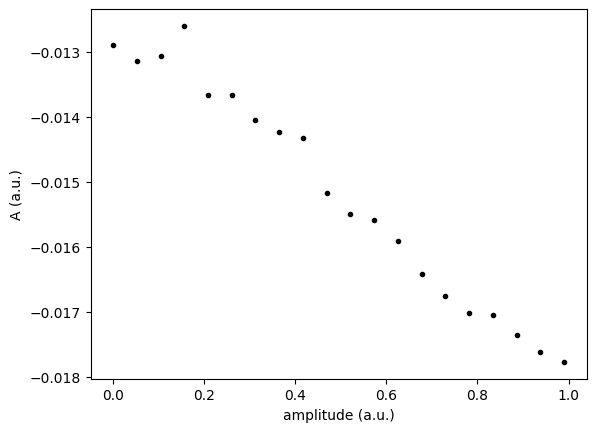

In [1485]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
# plt.axvline(0.55)
# pi_amp = 0.95

In [1486]:
# rabi_amplitude = pi_amp
measure_q.parameters.user_defined['amplitude_pi'] = 0.99

# On-chip flux line

## Resonator vs flux 

### resonator spectroscopy setup

In [1525]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -10e6
stop_freq = 10e6
num_points = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

readout_pulse = create_readout_pulse(measure_q)

In [1526]:
2**10

1024

In [1527]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.51,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

#### 3.2.2 Experiment Definition

In [1528]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [1529]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [1530]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [1531]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.30 13:23:53.176] INFO    Starting LabOne Q Compiler run...
[2024.07.30 13:23:53.189] INFO    Schedule completed. [0.010 s]
[2024.07.30 13:23:53.214] INFO    Code generation completed for all AWGs. [0.023 s]
[2024.07.30 13:23:53.216] INFO    Completed compilation step 1 of 1. [0.036 s]
[2024.07.30 13:23:53.219] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 13:23:53.220] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 13:23:53.221] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 13:23:53.222] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.30 13:23:53.224] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 13:23:53.225] INFO      TOTAL                      23            0                  8000  
[2024.07.30 13:23:53.226] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-30-13-23-53.html

#### 3.2.4 Run and Evaluate Experiment

In [1532]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.30 13:23:58.185] INFO    Configuring the device setup
[2024.07.30 13:23:58.289] INFO    The device setup is configured
[2024.07.30 13:23:59.356] INFO    Starting near-time execution...
[2024.07.30 13:24:01.057] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T132401.json


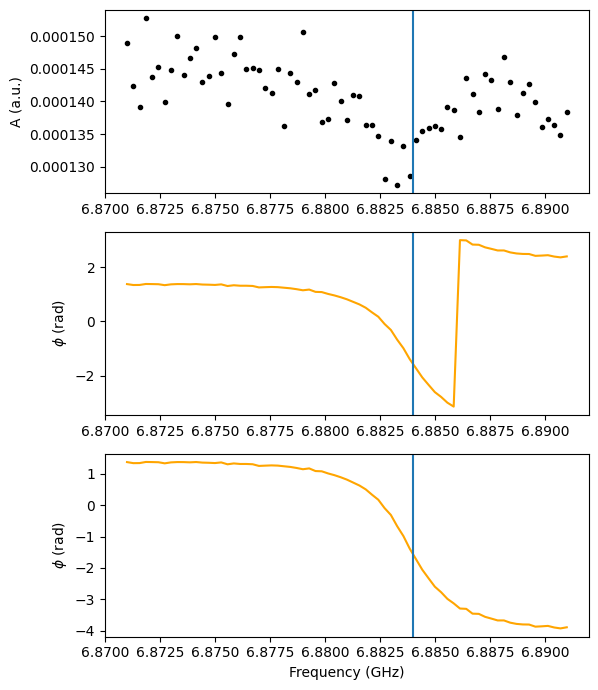

In [1539]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.8840]
for _vl in vl:
    ax1.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax2.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax3.axvline(_vl, ls='-', 
                # color='tab:blue',
               )

plt.tight_layout()
plt.show()

### f_r vs phi ext

In [365]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.02s


KeyError: 'Another instrument has the name: yoko'

In [237]:
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [238]:
dc.output('off')
dc.source_mode('CURR')

In [1524]:
dc.ramp_current(0e-3, 0.5e-6,0)

In [239]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

In [1007]:
import sys

In [1540]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(10e-3)

start_curr = 0e-3
stop_curr = 10e-3
current_sweep = np.linspace(start_curr,stop_curr, 101)

dc.ramp_current(0e-3, 1e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

# dc.ramp_current(0,0.5e-6,0)
# dc.output('off')

step 0
current: 0.0
[2024.07.30 13:27:25.443] INFO    Configuring the device setup
[2024.07.30 13:27:25.560] INFO    The device setup is configured
[2024.07.30 13:27:26.824] INFO    Starting near-time execution...
[2024.07.30 13:27:28.388] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T132728.json
step 1
current: 0.0001
[2024.07.30 13:27:30.675] INFO    Starting near-time execution...
[2024.07.30 13:27:32.262] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T132732.json
step 2
current: 0.0002
[2024.07.30 13:27:34.535] INFO    Starting near-time execution...
[2024.07.30 13:27:36.134] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T132736.json
step 3
current: 0.00030000000000000003
[2024.07.30 13:27:38.447] INFO    Starting near-time execution...
[2024.07.30 13:27:40.125] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pul

Text(0.5, 1.0, 'LogMag [arb.]')

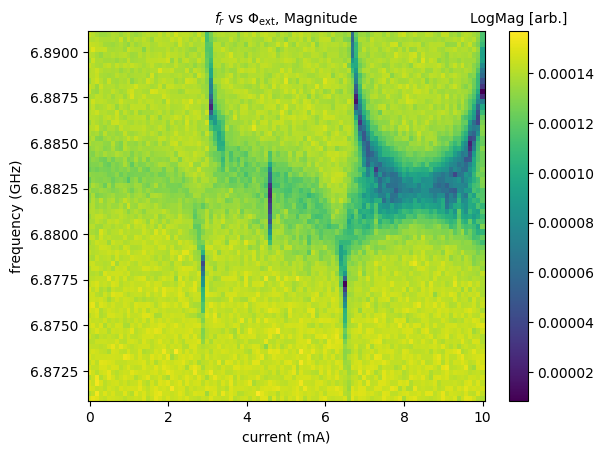

In [1541]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

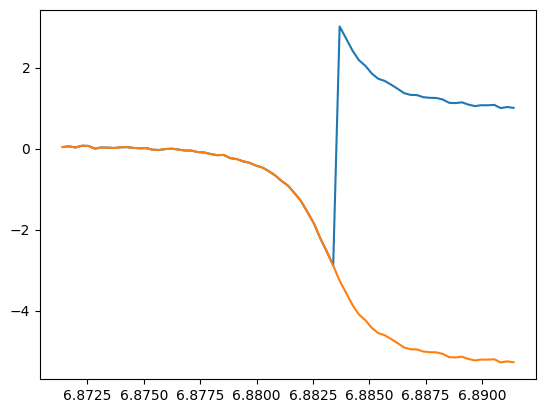

In [1129]:
electrical_delay = 60.65e-9
plt.plot(spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results[0]).T)
plt.plot(spec_freq/1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results[0]).T))

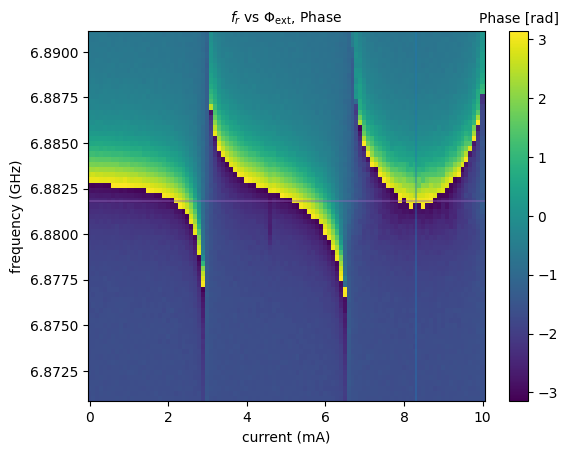

In [1548]:
electrical_delay = 60.61e-9
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(8.3, c='tab:blue', alpha=0.4)
plt.axhline(6.8818, c='tab:purple', alpha=0.4)

In [1577]:
dc.ramp_current(8.3e-3, 0.5e-6, 0)

# Two-tone

In [1416]:
dc.output('on')

In [1770]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
# qspec_num = 1001
qspec_num = 101

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 11

In [1771]:
### QB spec
measure_q.parameters.drive_lo_frequency = 1.3e9

LF_path = False
start_freq = -20e6
stop_freq = 20e6
measure_q.parameters.resonance_frequency_ge = 0.9721e9
# measure_q.parameters.user_defined['amplitude_pi'] = 0.99
measure_q.parameters.user_defined['amplitude_pi'] = 0.1

### RO spec
measure_q.parameters.readout_resonator_frequency = 6.881e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3


# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

# measure_q.parameters.drive_range = 5
measure_q.parameters.drive_range = -25
measure_q.parameters.user_defined['reset_length'] = 1e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 2000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=972100000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.1,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15,
│   │   │   'amplitude_pi/2': 0.33
│   │   }
│   )
)

In [1772]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [1773]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [1774]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [1775]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [1776]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(1e-06,
 LinearSweepParameter(uid='drive_freq_q0', start=-347900000.0, stop=-307900000.0, count=101, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q0', amplitude=0.95, length=2e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q0', amplitude=0.05, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [1777]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.30 14:58:03.026] INFO    Starting LabOne Q Compiler run...
[2024.07.30 14:58:03.039] INFO    Schedule completed. [0.011 s]
[2024.07.30 14:58:03.112] INFO    Code generation completed for all AWGs. [0.071 s]
[2024.07.30 14:58:03.114] INFO    Completed compilation step 1 of 1. [0.086 s]
[2024.07.30 14:58:03.117] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 14:58:03.119] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 14:58:03.120] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 14:58:03.121] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.30 14:58:03.122] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.30 14:58:03.124] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 14:58:03.125] INFO      TOTAL                         32 

In [1778]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.30 14:58:03.135] INFO    Configuring the device setup
[2024.07.30 14:58:03.243] INFO    The device setup is configured
[2024.07.30 14:58:04.165] INFO    Starting near-time execution...
[2024.07.30 14:58:06.023] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145806.json


In [1779]:
emulate=False

estimated frequency 0.9729 GHz


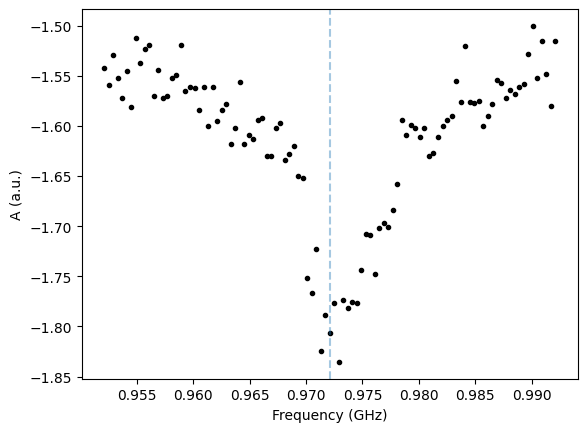

In [1780]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

plt.axvline(0.9721, linestyle = '--', alpha=0.4)
# plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

In [1781]:
measure_q.parameters.resonance_frequency_ge = 0.9721e9
device_setup.set_calibration(
    measure_q.calibration()
)

In [1629]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [1759]:
dc.ramp_current(8.3e-3, 1e-6, 0)

In [1854]:
dc.ramp_current(0, 1e-6, 0)

In [ ]:
dc.output('off')

## Two-tone vs flux
Fine two tone sweep to find half-flux

[2024.07.30 14:58:53.220] INFO    Configuring the device setup
[2024.07.30 14:58:53.329] INFO    The device setup is configured
[2024.07.30 14:58:54.188] INFO    Starting near-time execution...
[2024.07.30 14:58:56.051] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145856.json
[2024.07.30 14:58:57.856] INFO    Starting near-time execution...
[2024.07.30 14:58:59.678] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145859.json
[2024.07.30 14:59:01.434] INFO    Starting near-time execution...
[2024.07.30 14:59:03.271] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145903.json
[2024.07.30 14:59:05.438] INFO    Starting near-time execution...
[2024.07.30 14:59:07.379] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145907.json
[2024.07.30 14:59:09.288] INFO    Starting near-time execution...
[2024.07.30 14:59:11.105] INFO

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_47976\3660548031.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


[2024.07.30 15:00:13.018] INFO    Starting near-time execution...
[2024.07.30 15:00:15.032] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150015.json
[2024.07.30 15:00:16.767] INFO    Starting near-time execution...
[2024.07.30 15:00:18.628] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150018.json
[2024.07.30 15:00:20.567] INFO    Starting near-time execution...
[2024.07.30 15:00:22.416] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150022.json
[2024.07.30 15:00:24.445] INFO    Starting near-time execution...
[2024.07.30 15:00:26.233] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150026.json
[2024.07.30 15:00:28.069] INFO    Starting near-time execution...
[2024.07.30 15:00:29.907] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150030.json
[2024.07.30 15:00:31.858] INFO

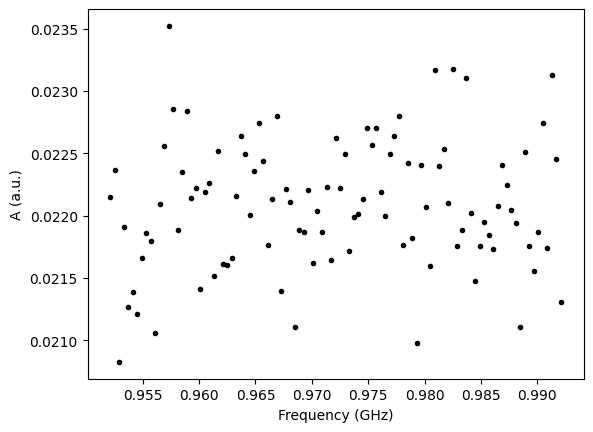

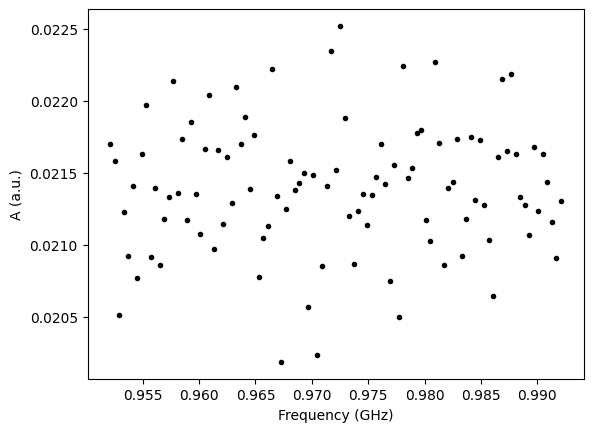

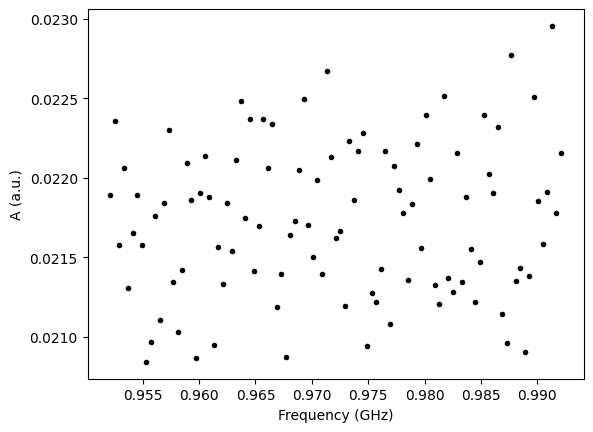

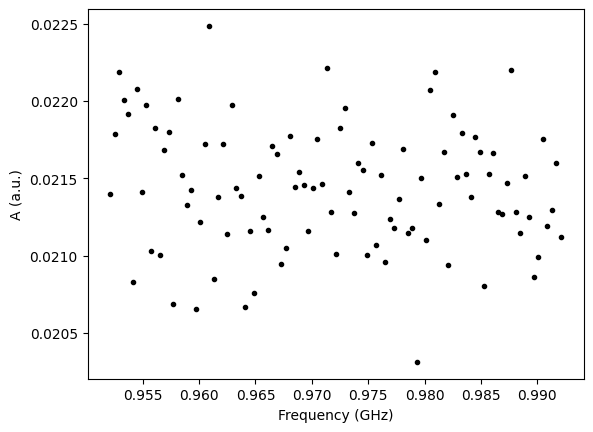

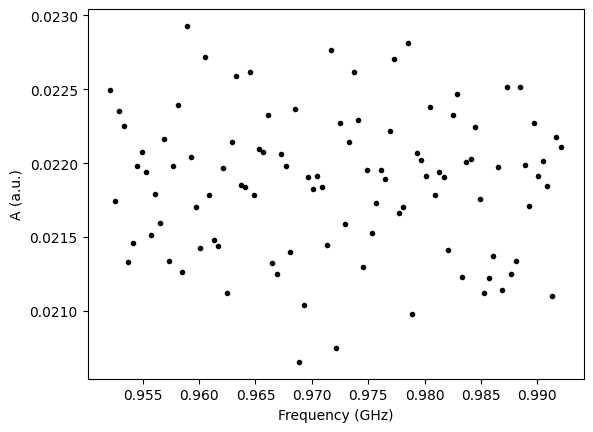

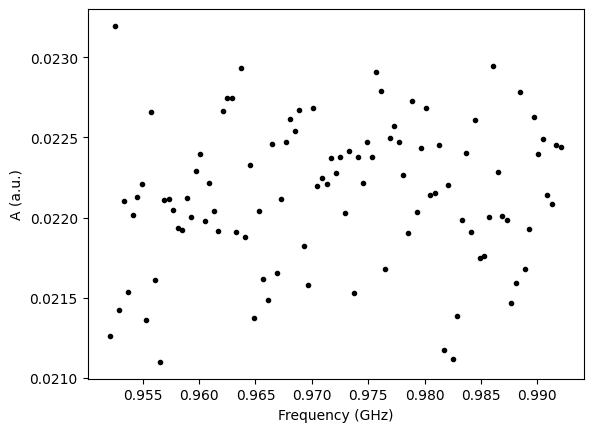

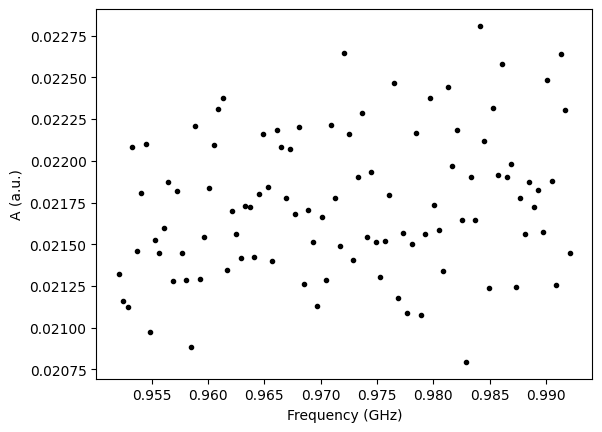

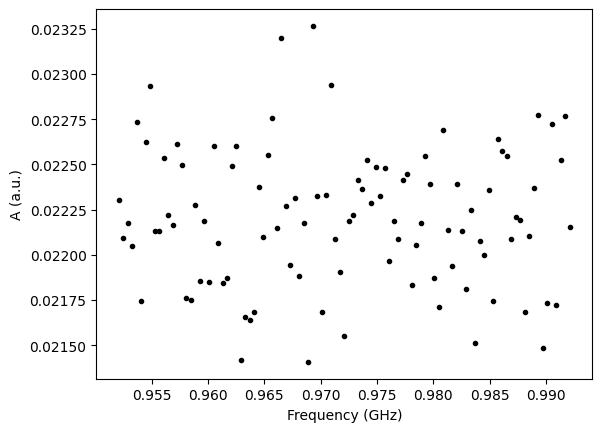

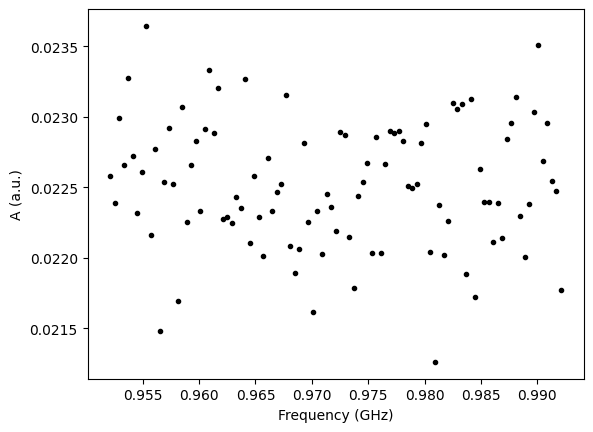

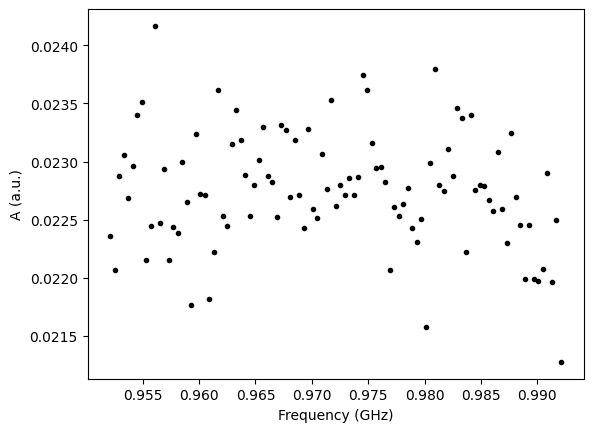

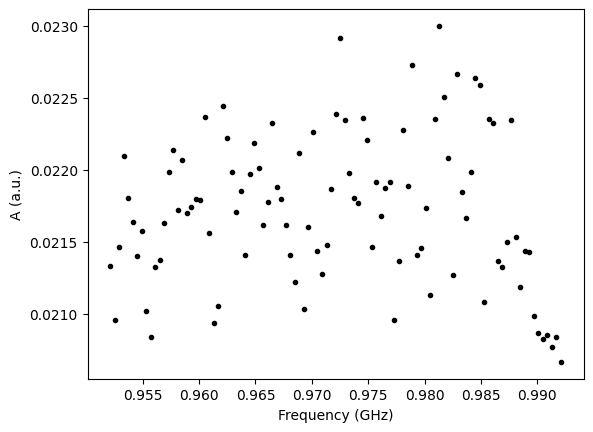

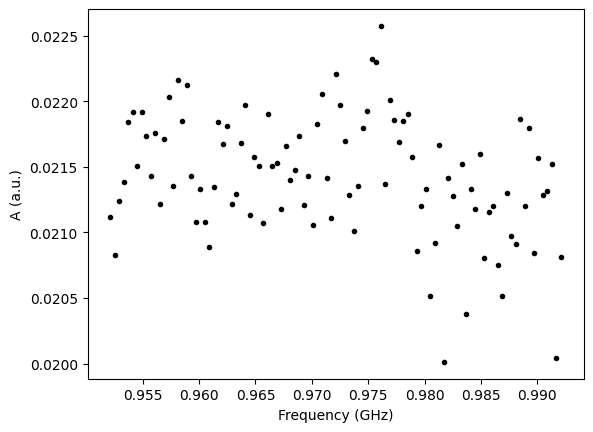

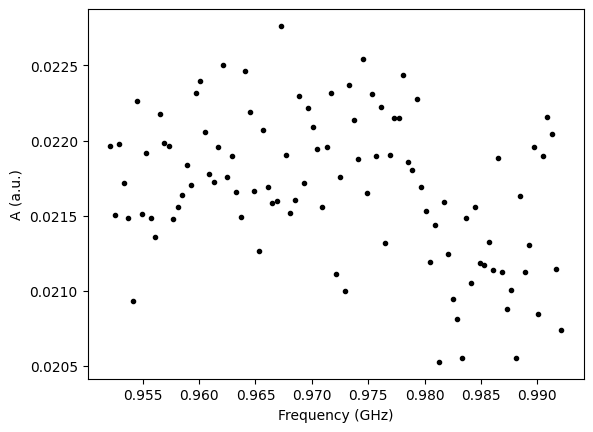

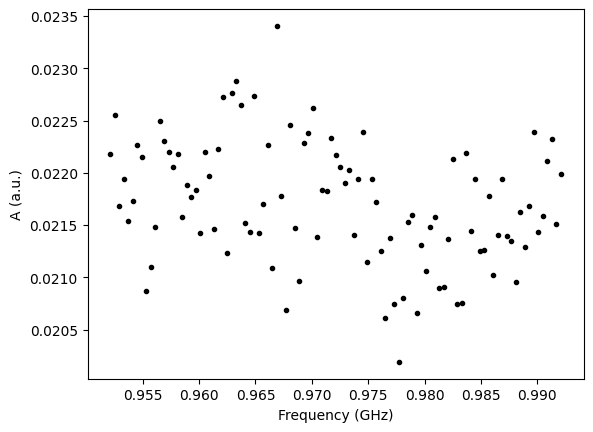

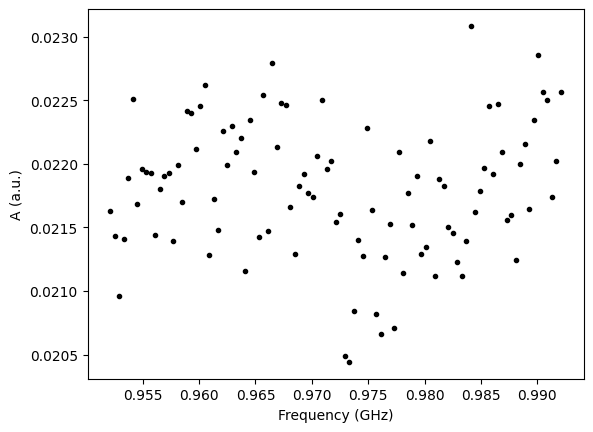

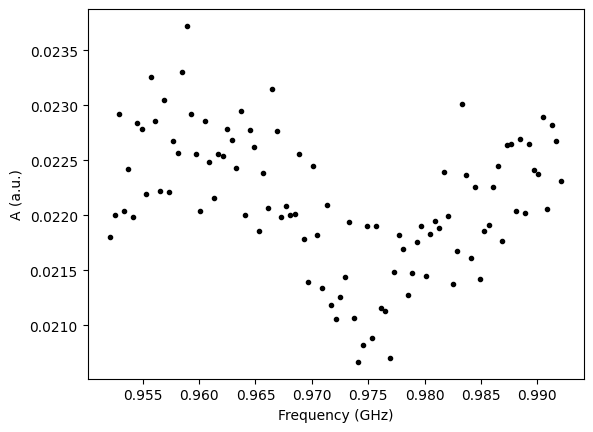

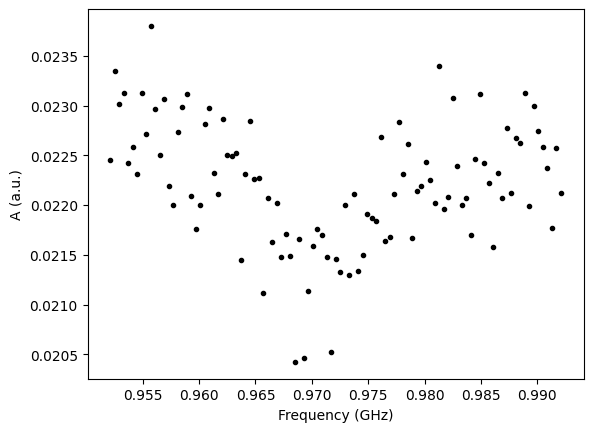

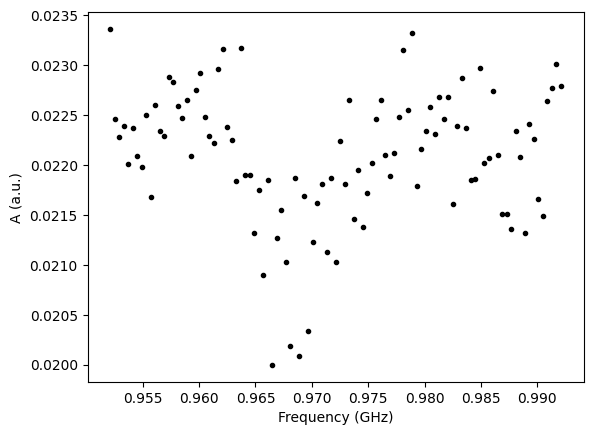

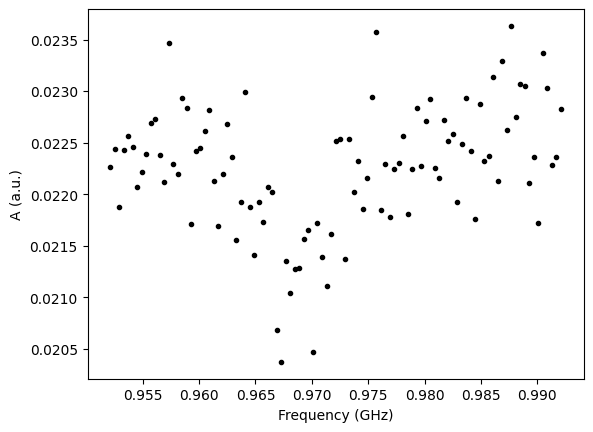

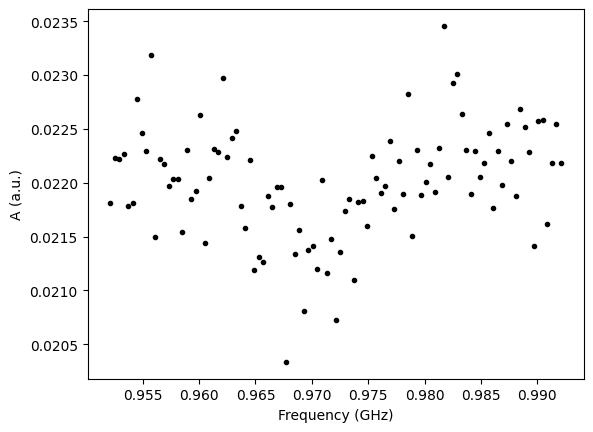

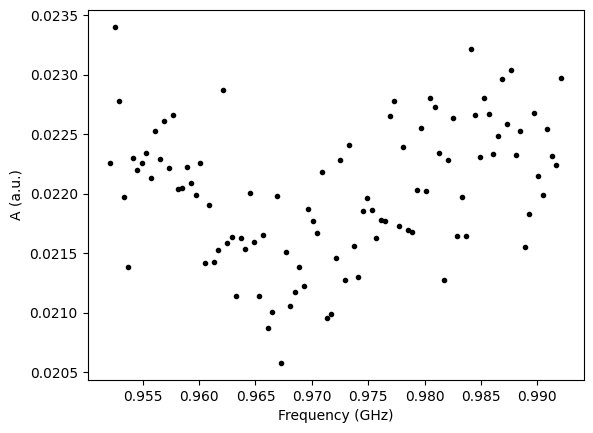

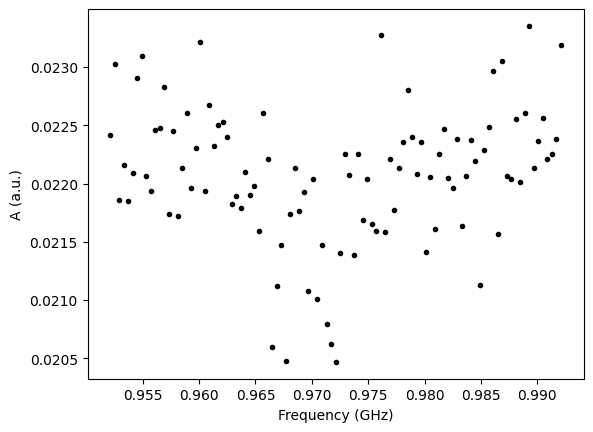

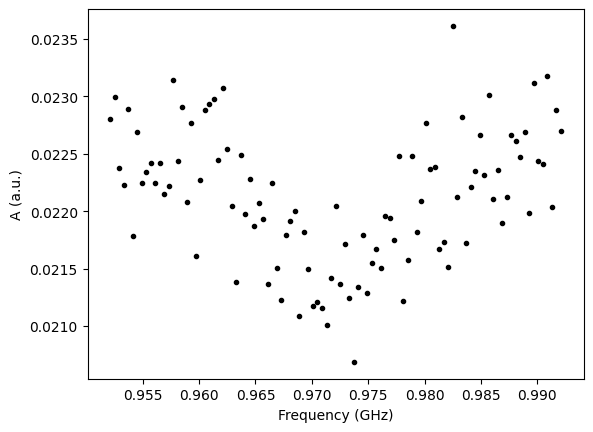

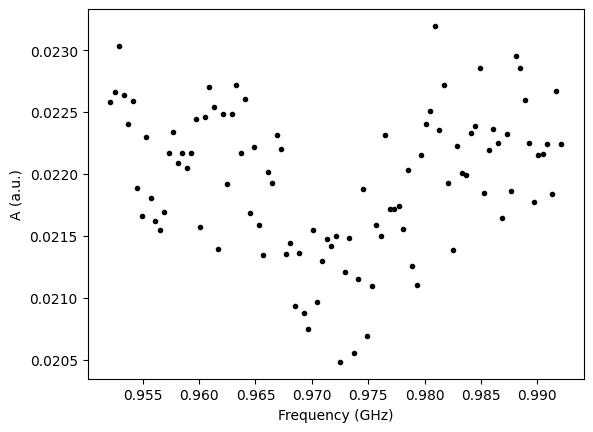

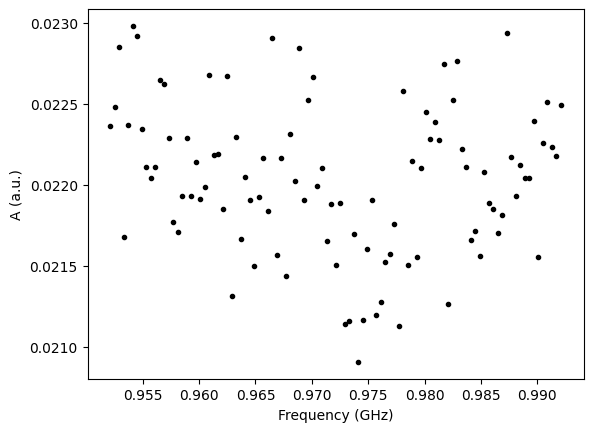

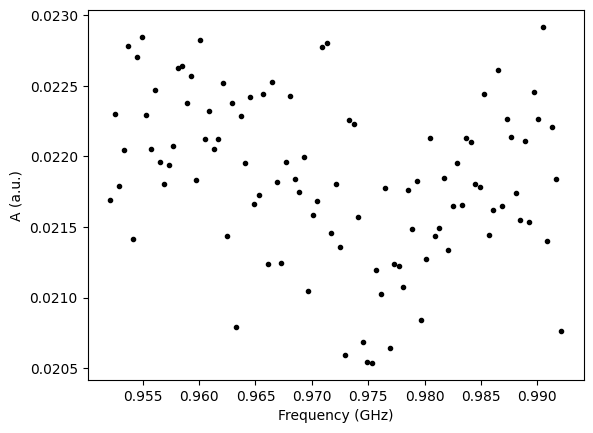

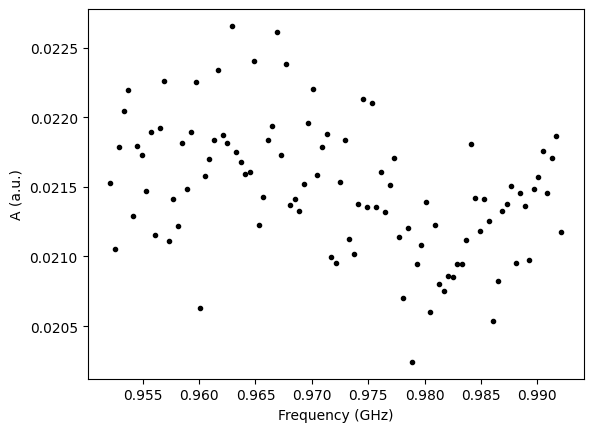

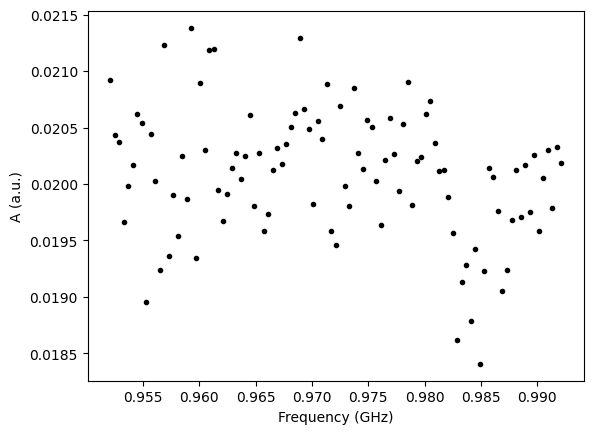

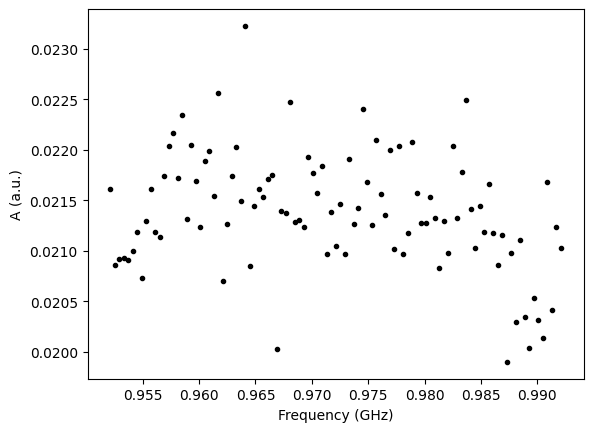

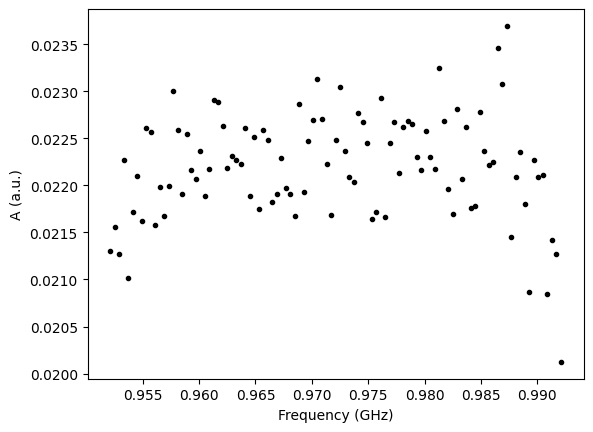

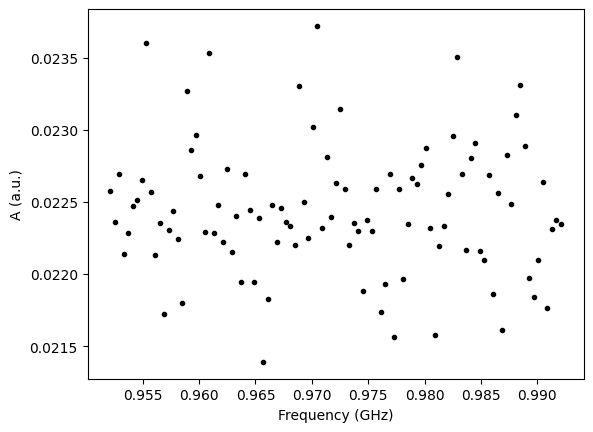

In [1782]:
dc.current_range(10e-3)
start = 8.0e-3
stop = 8.6e-3

current_sweep = np.linspace(start, stop, 31)
dc.output('on')
sweep_qspec_results = []
for current in current_sweep:
    dc.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)
    # run the experiment on qubit 0
    qspec_results = session.run()

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    sweep_qspec_results.append(qspec_res)

    # plot measurement data
    fig = plt.figure()
    plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
    plt.ylabel("A (a.u.)")
    plt.xlabel("Frequency (GHz)")

# plt.show()
# dc.ramp_current(5.5e-3,1e-5,0)

Text(0.5, 1.0, 'mag')

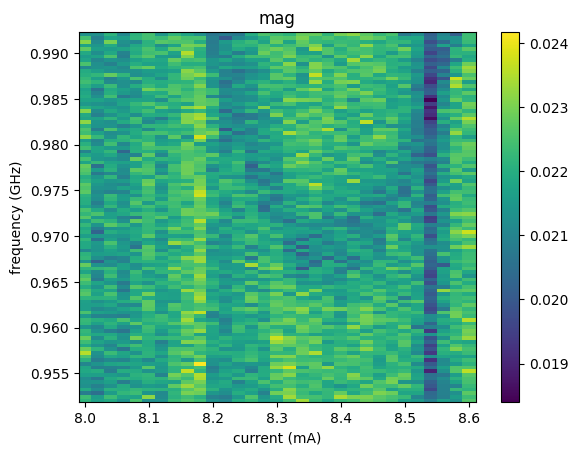

In [1783]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

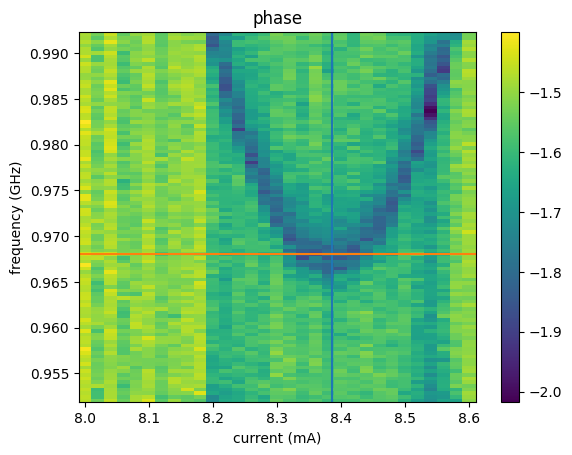

In [1805]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.angle(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
plt.axvline(08.385)
plt.axhline(0.968, color='tab:orange')
# current_sweep[8]*1e3

(0.96, 0.97)

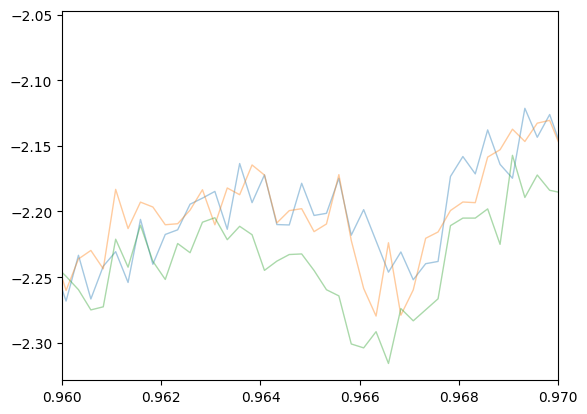

In [1462]:
plt.plot(qspec_freq/1e9, angle_data[:, 11], lw=1, alpha=0.4)
plt.plot(qspec_freq/1e9, angle_data[:, 10], lw=1, alpha=0.4)
plt.plot(qspec_freq/1e9, angle_data[:, 12], lw=1, alpha=0.4)
plt.xlim(0.96, 0.97)

In [1787]:
angle_data = np.angle(sweep_qspec_results).T
angle_data.shape

(101, 31)

In [1788]:
min_arr = np.argmin(angle_data, axis=0)
min_arr.shape

(31,)

In [1789]:
min_freqs = (qspec_freq/1e9)[min_arr]
min_freqs.shape

(31,)

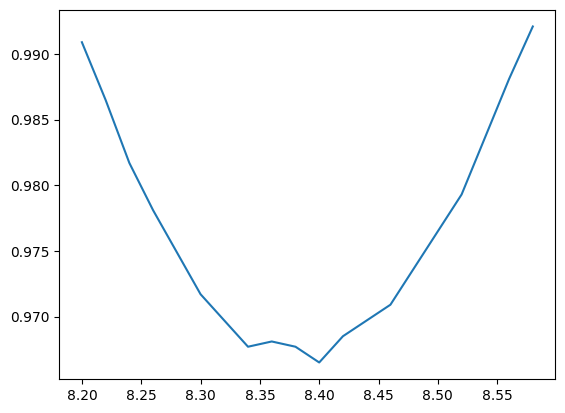

In [1794]:
# plt.plot( current_sweep*1e3, min_arr)
start = 10
stop = -1
plt.plot( (current_sweep*1e3)[start:stop], min_freqs[start:stop])

In [1799]:
min_freqs[start:stop]

array([0.9909, 0.9865, 0.9817, 0.9781, 0.9749, 0.9717, 0.9697, 0.9677,
       0.9681, 0.9677, 0.9665, 0.9685, 0.9697, 0.9709, 0.9737, 0.9765,
       0.9793, 0.9837, 0.9881, 0.9921])

In [1798]:
np.argmin(min_freqs[start:stop])

10

In [1800]:
current_sweep[np.argmin(min_freqs[start:stop])+start]

0.0084

In [1802]:
dc.ramp_current(8.385e-3, 1e-6, 0)

### 3.6 Amplitude Rabi Experiment

Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles

#### 3.6.1 Additional Experimental Parameters

Define the amplitude sweep range and qubit excitation pulse

In [1809]:
measure_q.parameters.resonance_frequency_ge = 0.967e9
# measure_q.parameters.user_defined['pulse_length'] = 50e-9
measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15,
│   │   │   'amplitude_pi/2': 0.33
│   │   }
│   )
)

In [1810]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 20
amp_min=0.0
amp_max=0.99


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [1811]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [1812]:
def create_rabi_amp_sweep(qubit, amp_num, amp_min=0.1, amp_max=0.22, uid="rabi_amp"):
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

In [1813]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes, amp_min=amp_min, amp_max=amp_max), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.07.30 15:08:56.507] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:08:56.512] INFO    Schedule completed. [0.002 s]
[2024.07.30 15:08:56.533] INFO    Code generation completed for all AWGs. [0.020 s]
[2024.07.30 15:08:56.535] INFO    Completed compilation step 1 of 1. [0.025 s]
[2024.07.30 15:08:56.539] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:08:56.540] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 15:08:56.541] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:08:56.543] INFO      device_shfqc        0         11            0           1      8000  
[2024.07.30 15:08:56.544] INFO      device_shfqc_sg     0         71           20           2     16000  
[2024.07.30 15:08:56.545] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:08:56.546] INFO      TOTAL                         82 

#### 3.6.4 Show Pulse Sheet

In [1814]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.07.30 15:08:56.556] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 15:08:56.558] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:08:56.566] INFO    Schedule completed. [0.005 s]
[2024.07.30 15:08:56.587] INFO    Code generation completed for all AWGs. [0.019 s]
[2024.07.30 15:08:56.588] INFO    Completed compilation step 1 of 1. [0.027 s]
[2024.07.30 15:08:56.590] INFO    Finished LabOne Q Compiler run.
[2024.07.30 15:08:56.604] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-15-08-56.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-15-08-56.html

#### 3.6.5 Plot Simulated Outputs

In [1815]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [1816]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.07.30 15:08:56.649] INFO    Configuring the device setup
[2024.07.30 15:08:56.763] INFO    The device setup is configured
[2024.07.30 15:08:57.810] INFO    Starting near-time execution...
[2024.07.30 15:08:58.292] INFO    Estimated RT execution time: 17.04 s.
[2024.07.30 15:09:15.560] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240730T150915.json


In [1817]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = oscillatory(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(
        len(rabi_amp)
    )

Fitted parameters: [ 5.21089129e+00  3.30038534e+00 -4.70766613e-03 -4.40920883e-03]


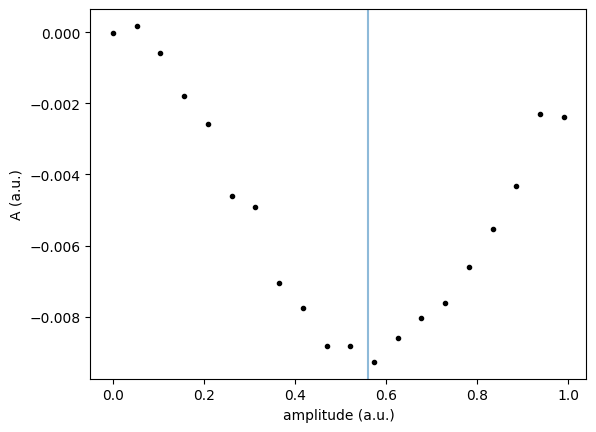

In [1821]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
plt.axvline(0.56, alpha=0.5)
# plt.axvline(0.33, alpha=0.5)
# pi_amp = 0.95

In [1822]:
# rabi_amplitude = pi_amp
measure_q.parameters.user_defined['amplitude_pi'] = 0.56
# measure_q.parameters.user_defined['amplitude_pi/2'] = 0.33

# T1

#### 3.7.1 Experiment Parameters

In [1823]:
# measure_q.parameters.user_defined['amplitude_pi'] = 0.95
# measure_q.parameters.user_defined['pulse_length'] = 20e-6
# measure_q.parameters.drive_range = 10

In [1824]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.56,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15,
│   │   │   'amplitude_pi/2': 0.33
│   │   }
│   )
)

In [1825]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 20
start_delay = 0e-6
stop_delay = 200e-6


#### 3.7.2 Experiment Definition

In [1826]:
# function that returns a T1 experiment


def T1(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_T1 = Experiment(
        uid="T1 Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define T1 experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_T1.acquire_loop_rt(
        uid="T1_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        
        # inner loop - real time sweep of T1 time delays
        with exp_T1.sweep(
            uid="T1_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - delay is swept
            with exp_T1.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_T1.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_T1.delay(signal="drive", time=time_sweep)
            # readout pulse and data acquisition
            with exp_T1.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_T1.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_T1.acquire(
                    signal="acquire",
                    handle="T1",
                    kernel=readout_pulse,
                )
            with exp_T1.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_T1.reserve(signal="measure")
    return exp_T1

#### 3.7.3 Create Experiment and Signal Map

In [1827]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_T1_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

T1_exp = T1(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

T1_exp.set_signal_map(signal_map_default(measure_q))

compiled_T1 = session.compile(T1_exp)

[2024.07.30 15:10:12.944] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:10:12.949] INFO    Schedule completed. [0.002 s]
[2024.07.30 15:10:12.971] INFO    Code generation completed for all AWGs. [0.021 s]
[2024.07.30 15:10:12.972] INFO    Completed compilation step 1 of 1. [0.026 s]
[2024.07.30 15:10:12.976] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:10:12.977] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 15:10:12.978] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:10:12.979] INFO      device_shfqc        0        112            0           1      8000  
[2024.07.30 15:10:12.981] INFO      device_shfqc_sg     0        148           16          16    128480  
[2024.07.30 15:10:12.982] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:10:12.983] INFO      TOTAL                        260 

#### 3.7.4 Show Pulse Sheet

In [1828]:
show_pulse_sheet("Pulse_Sheets/T1", compiled_T1)

[2024.07.30 15:10:12.992] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 15:10:12.995] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:10:13.002] INFO    Schedule completed. [0.006 s]
[2024.07.30 15:10:13.023] INFO    Code generation completed for all AWGs. [0.020 s]
[2024.07.30 15:10:13.025] INFO    Completed compilation step 1 of 1. [0.028 s]
[2024.07.30 15:10:13.026] INFO    Finished LabOne Q Compiler run.
[2024.07.30 15:10:13.041] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-07-30-15-10-12.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-07-30-15-10-12.html

#### 3.7.5 Plot Simulated Outputs

In [1829]:
# plot_simulation(compiled_T1, 100e-6, 150e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [1830]:
# run the compiled experiemnt
T1_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/T1_results_{timestamp}.json")
print(f"File saved as Results_Needed/T1_results_{timestamp}.json")

[2024.07.30 15:10:28.558] INFO    Configuring the device setup
[2024.07.30 15:10:28.668] INFO    The device setup is configured
[2024.07.30 15:10:29.606] INFO    Starting near-time execution...
[2024.07.30 15:10:30.174] INFO    Estimated RT execution time: 33.42 s.
[2024.07.30 15:11:03.837] INFO    Finished near-time execution.
File saved as Results_Needed/T1_results_20240730T151104.json


In [1831]:
# get measurement data returned by the instruments
T1_res = T1_results.get_data("T1")

# define time axis from qubit parameters
T1_delay = T1_results.get_axis("T1")[0]

if emulate:
    # create dummy data if running in emulation mode
    T1_res = exponential_decay(
        T1_delay, 2e5, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(T1_delay))

Text(0.5, 0, 'delay (us)')

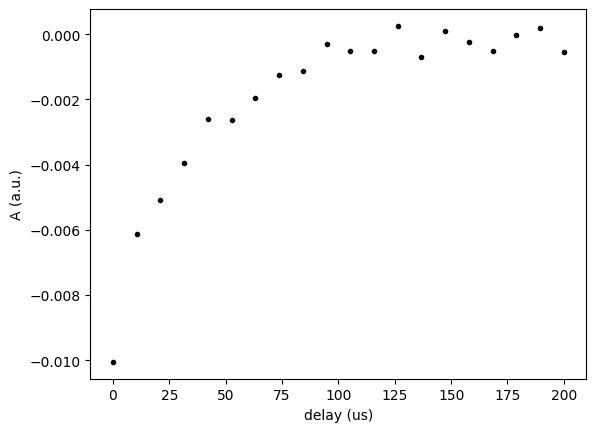

In [1832]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay*1e6, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

Fitted parameters: [ 2.97601160e+04 -1.35771450e-04 -9.39095073e-03]
T1 time 33.60201953463509 us


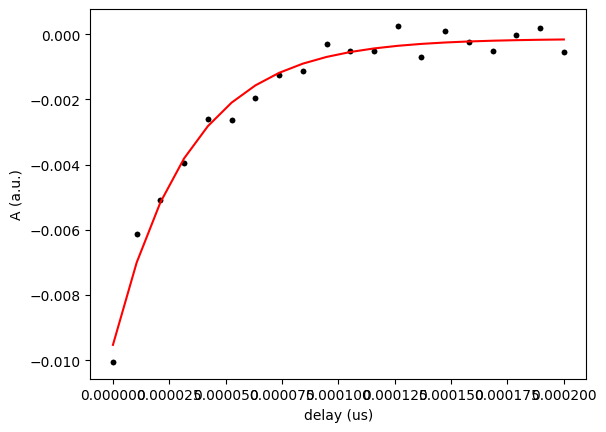

In [1833]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

# increase number of plot points for smooth plotting of fit results
#delay_plot = np.linspace(T1_delay[0], T1_delay[-1], 5 * len(T1_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = exponential_decay.fit(
   T1_delay,
   T1_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 
# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

### 3.7 Ramsey Experiment
The Ramsey experiment is different from the experiments above as the length of the drive section changes. Using a right-aligned sweep section and the automatic repetition time makes sure that the experiment is run as efficiently as possible on the Zurich Instruments hardware.

#### 3.7.1 Experiment Parameters

In [1834]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 21
start_delay = 0e-6
stop_delay = 30e-6


#### 3.7.2 Experiment Definition

In [1835]:
# function that returns a Ramsey experiment


def ramsey(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_ramsey = Experiment(
        uid="Ramsey Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - pulse delay is swept
            with exp_ramsey.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_ramsey.delay(signal="drive", time=time_sweep)
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_ramsey.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_ramsey.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey.acquire(
                    signal="acquire",
                    handle="ramsey",
                    kernel=readout_pulse,
                )
            with exp_ramsey.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_ramsey.reserve(signal="measure")
    return exp_ramsey

In [1836]:
# #measure_q.parameters.user_defined['reset_length'] = 1e-3
# measure_q.parameters.resonance_frequency_ge = measure_q.parameters.resonance_frequency_ge
# print(measure_q)

#### 3.7.3 Create Experiment and Signal Map

In [1837]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_ramsey_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

ramsey_exp = ramsey(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

ramsey_exp.set_signal_map(signal_map_default(measure_q))

compiled_ramsey = session.compile(ramsey_exp)

[2024.07.30 15:11:52.044] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:11:52.050] INFO    Schedule completed. [0.002 s]
[2024.07.30 15:11:52.073] INFO    Code generation completed for all AWGs. [0.022 s]
[2024.07.30 15:11:52.075] INFO    Completed compilation step 1 of 1. [0.028 s]
[2024.07.30 15:11:52.078] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:11:52.080] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 15:11:52.081] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:11:52.082] INFO      device_shfqc        0         89            0           1      8000  
[2024.07.30 15:11:52.083] INFO      device_shfqc_sg     0        115            2           2     16032  
[2024.07.30 15:11:52.084] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:11:52.086] INFO      TOTAL                        204 

#### 3.7.4 Show Pulse Sheet

In [1838]:
show_pulse_sheet("Pulse_Sheets/Ramsey", compiled_ramsey)

[2024.07.30 15:11:52.096] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 15:11:52.098] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:11:52.106] INFO    Schedule completed. [0.006 s]
[2024.07.30 15:11:52.128] INFO    Code generation completed for all AWGs. [0.021 s]
[2024.07.30 15:11:52.130] INFO    Completed compilation step 1 of 1. [0.029 s]
[2024.07.30 15:11:52.131] INFO    Finished LabOne Q Compiler run.
[2024.07.30 15:11:52.145] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Ramsey_2024-07-30-15-11-52.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Ramsey_2024-07-30-15-11-52.html

#### 3.7.5 Plot Simulated Outputs

In [1839]:
# plot_simulation(compiled_ramsey, 50e-6, 100e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [1840]:
# run the compiled experiemnt
ramsey_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/ramsey_results_{timestamp}_.json")
print(f"File saved as Results/ramsey_results_{timestamp}_.json")

[2024.07.30 15:12:07.264] INFO    Configuring the device setup
[2024.07.30 15:12:07.378] INFO    The device setup is configured
[2024.07.30 15:12:08.337] INFO    Starting near-time execution...
[2024.07.30 15:12:08.888] INFO    Estimated RT execution time: 20.82 s.
[2024.07.30 15:12:29.948] INFO    Finished near-time execution.
File saved as Results/ramsey_results_20240730T151230_.json


In [1841]:
# get measurement data returned by the instruments
ramsey_res = ramsey_results.get_data("ramsey")

# define time axis from qubit parameters
ramsey_delay = ramsey_results.get_axis("ramsey")[0]

if emulate:
    # create dummy data if running in emulation mode
    ramsey_res = oscillatory_decay(
        ramsey_delay, 1e6, 0, 1 / 10e-6, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(ramsey_delay))

Fitted parameters: [ 4.48975440e+05 -5.50027729e+00  5.82476561e+04 -4.40618666e-03
 -4.80168842e-03]


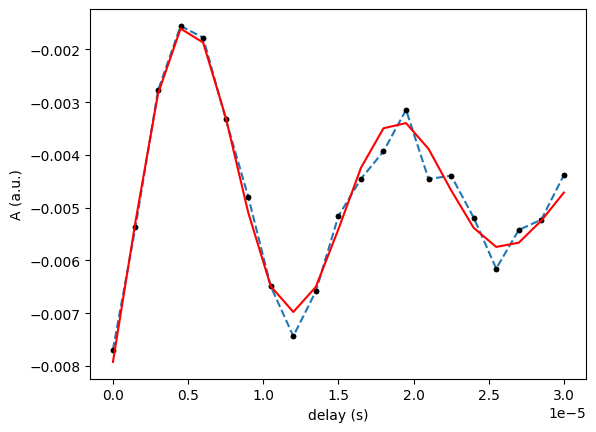

In [1842]:
# plot measurement results
fig = plt.figure()
plt.plot(ramsey_delay, ramsey_res, ".k")
plt.plot(ramsey_delay, ramsey_res, linestyle ='--')

plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(ramsey_delay[0], ramsey_delay[-1], 5 * len(ramsey_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    ramsey_delay,
    ramsey_res,
    1/5e-6,
    0,
    1 / 10e-6,
    0.002,
    0.0008,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [1843]:
print(f'T2 Ramsey = {1e6/popt[2]} us')

T2 Ramsey = 17.16807280861634 us


### Ramsey Heralded

In [ ]:
# function that returns a Ramsey experiment


def ramsey_herald(drive_pulse, readout_pulse, time_sweep, num_averages = 8, relax_time = 5e-6):
    exp_ramsey_herald = Experiment(
        uid="Ramsey Experiment_herald",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey_herald.acquire_loop_rt(
        uid="ramsey_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey_herald.sweep(
            uid="ramsey_sweep_herald", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            with exp_ramsey_herald.section(
                uid="readout_section_herald"
            ):
                # play readout pulse on measure line
                exp_ramsey_herald.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey_herald.acquire(
                    signal="acquire",
                    handle="ramsey_herald",
                    kernel=readout_pulse,
                )
            
            # play qubit excitation pulse - pulse delay is swept
            with exp_ramsey_herald.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT, play_after="readout_section_herald"
            ):
                exp_ramsey_herald.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_ramsey_herald.delay(signal="drive", time=time_sweep)
                exp_ramsey_herald.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_ramsey_herald.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_ramsey_herald.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey_herald.acquire(
                    signal="acquire",
                    handle="ramsey",
                    kernel=readout_pulse,
                )
            with exp_ramsey_herald.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_ramsey_herald.reserve(signal="measure")
    return exp_ramsey_herald

### 3.9 echo Experiment
Adding a Y180 pulse in middle of Ramsey

In [1844]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 21
start_delay = 0e-6
stop_delay = 60e-6


#### 3.9.2 Experiment Definition

In [1845]:
# function that returns an Echo experiment


def echo(x90_pulse, y180_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_echo = Experiment(
        uid="Echo Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Echo experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_echo.acquire_loop_rt(
        uid="echo_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of echo time delays
        with exp_echo.sweep(
            uid="echo_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse
            with exp_echo.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=y180_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_echo.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_echo.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_echo.acquire(
                    signal="acquire",
                    handle="echo",
                    kernel=readout_pulse,
                )
            with exp_echo.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_echo.reserve(signal="measure")
    return exp_echo

In [1846]:
# measure_q.parameters.resonance_frequency_ge = 4.5509e9+190e3
# measure_q.parameters.user_defined['reset_length'] = 5e-3
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.56,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15,
│   │   │   'amplitude_pi/2': 0.33
│   │   }
│   )
)

#### 3.9.3 Create Experiment and Signal Map

In [1847]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
x90_pulse = create_pi_2_pulse(measure_q)
y180_pulse = create_pi_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

echo_exp = echo(
    x90_pulse=x90_pulse, y180_pulse=y180_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

echo_exp.set_signal_map(signal_map_default(measure_q))

compiled_echo = session.compile(echo_exp)

[2024.07.30 15:13:12.448] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:13:12.455] INFO    Schedule completed. [0.004 s]
[2024.07.30 15:13:12.481] INFO    Code generation completed for all AWGs. [0.025 s]
[2024.07.30 15:13:12.483] INFO    Completed compilation step 1 of 1. [0.032 s]
[2024.07.30 15:13:12.486] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:13:12.487] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 15:13:12.489] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:13:12.490] INFO      device_shfqc        0         90            0           1      8000  
[2024.07.30 15:13:12.491] INFO      device_shfqc_sg     0        159            3           3     24032  
[2024.07.30 15:13:12.493] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:13:12.494] INFO      TOTAL                        249 

#### 3.9.4 Show Pulse Sheet

In [1848]:
show_pulse_sheet("Pulse_Sheets/echo", compiled_echo)

[2024.07.30 15:13:12.504] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 15:13:12.506] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:13:12.514] INFO    Schedule completed. [0.006 s]
[2024.07.30 15:13:12.572] INFO    Code generation completed for all AWGs. [0.056 s]
[2024.07.30 15:13:12.574] INFO    Completed compilation step 1 of 1. [0.065 s]
[2024.07.30 15:13:12.577] INFO    Finished LabOne Q Compiler run.
[2024.07.30 15:13:12.603] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\echo_2024-07-30-15-13-12.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\echo_2024-07-30-15-13-12.html

#### 3.9.5 Plot Simulated Outputs

In [1849]:
# plot_simulation(compiled_echo, 4000e-6, 4050e-6, plot_width=10)

#### 3.9.6 Run, Save, and Plot Results

In [1850]:
# run the compiled experiemnt
echo_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/echo_results_{timestamp}.json")
print(f"File saved as Results/echo_results_{timestamp}.json")

[2024.07.30 15:13:27.591] INFO    Configuring the device setup
[2024.07.30 15:13:27.699] INFO    The device setup is configured
[2024.07.30 15:13:28.786] INFO    Starting near-time execution...
[2024.07.30 15:13:29.308] INFO    Estimated RT execution time: 23.74 s.
[2024.07.30 15:13:53.310] INFO    Finished near-time execution.
File saved as Results/echo_results_20240730T151353.json


In [1851]:
# get measurement data returned by the instruments
echo_res = echo_results.get_data("echo")

# define time axis from qubit parameters
echo_delay = echo_results.get_axis("echo")[0]


Fitted parameters: [ 5.43250430e+04 -4.70847487e-03  4.16884189e-03]
T2e time 18.407716682173852 us


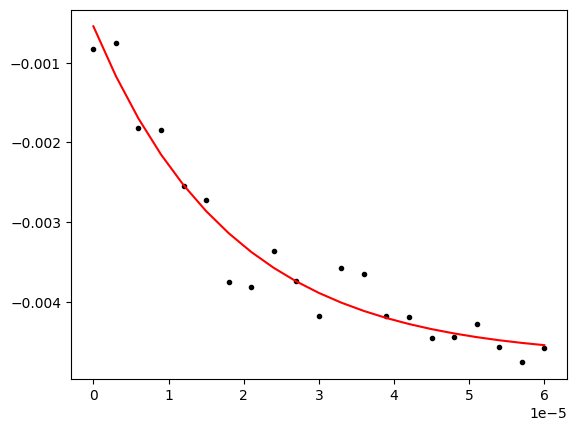

In [1852]:
popt, pcov = exponential_decay.fit(
   echo_delay,
   echo_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

Fitted parameters: [ 5.43250430e+04 -4.70847487e-03  4.16884189e-03]
T2e time 18.407716682173852 us


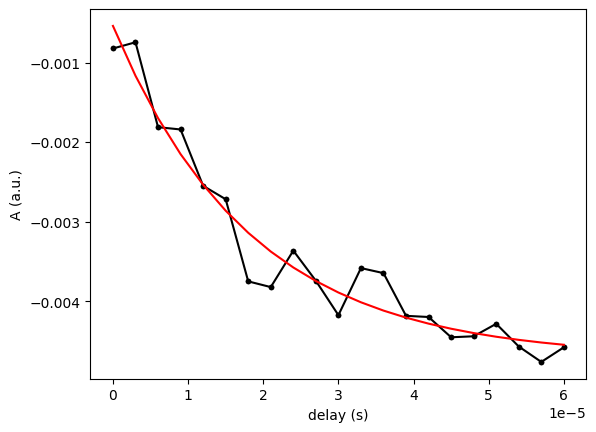

In [1853]:
# plot measurement results (XXX) 5 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel(r"delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

popt, pcov = exponential_decay.fit(
   echo_delay,
   echo_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 